# Car price prediction

This project was created during an ML course I took. 
It Allowed me to push myself even further during the course and achieve even better results. 
This problem was previously solved during a Kaggle competition, so I also had opportunity to compare my score with others.

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import defaultdict, Counter

import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Importing data:

Each entry in this database is a car with 155 features including car_price -> target variable

There are two subsets of data: train and test (test set is missing target variable), but for now they will be merged together.

In [17]:
train = pd.read_hdf('../car.h5')
test = pd.read_hdf('../test.car_price.h5')
print(train.shape)
print(test.shape)
train.sample()

(106494, 155)
(54122, 153)


,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
32199,"[Osobowe, BMW, Seria 2]","12:29, 2 marca 2018",PLN,"Cena Netto, Faktura VAT",56900.0,"Złocieniec, drawski, Zachodniopomorskie",None,Osoba prywatna,False,True,...,None,Używane,None,None,None,None,None,None,None,32199


In [18]:
df = pd.concat([train, test], sort=False)
del train, test
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160616 entries, 0 to 160613
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 116.1+ MB


Dataframe is to large for all information to show with default settings, so the settings were changed

In [19]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
df.head(3)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False

In [20]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

After preliminary data analysis there are few main issues to deal with:
- Target variable (car price) is in two currencies
- Some features are stored in two columns at the same time for example: 'param_liczba-drzwi' and 'param_door-count'
- Numerical data is stored as text

So starting with target variable it was normalized into one currency. For now fixed exchange rate was used equal 4.5. In effect a new target variable was created 'price_value_PLN'

In [21]:
df['price_currency'].value_counts()

PLN    160288
EUR       328
Name: price_currency, dtype: int64

In [22]:
def normalize_price_value(x):
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5
    
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

In [23]:
df.sample(5)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN
6146,"[Osobowe, Volvo, XC 90, Volvo XC 90 I (2002-20...","22:39, 2 marca 2018",PLN,"Cena Brutto, Do negocjacji",32000.0,"Proszowice, proszowicki, Małopolskie",None,Osoba prywatna,False,True,True,True,False,False,True,True,True,True,True,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,True,False,True,True,False,True,True,True,False,False,False,False,True,False,True,True,True,False,True,False,False,False,False,True,True,False,True,True,F

Target variable has a 'long tale' distribution so alternative logarithmic target variable 'price_value_PLN_log' was created, which in theory can be easier to predict. Later both target variables will be used to check which one is easier to predict.

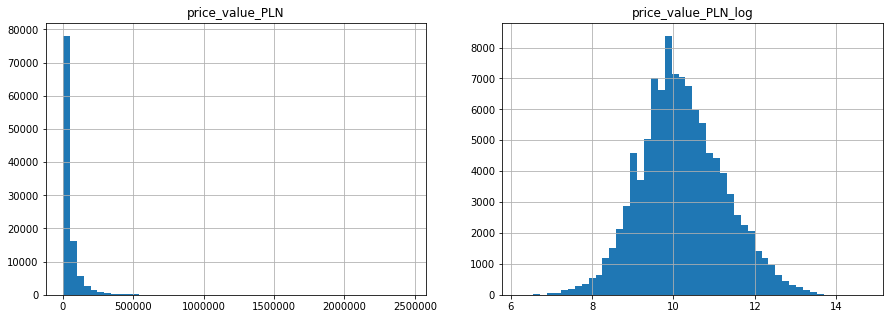

In [24]:
df['price_value_PLN_log'] = np.log1p(df['price_value_PLN'])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['price_value_PLN'].hist(bins=50);
plt.title('price_value_PLN');
plt.subplot(1,2,2)
df['price_value_PLN_log'].hist(bins=50);
plt.title('price_value_PLN_log');

For now to speed up first model development all missing data was replaced with -1. Later in error analysis it will be decided if that simple solution is good enough.

In [25]:
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

9013997


0

For reference a dummy model was created.

In [26]:
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

33565.50506397786

# feature engineering 

Standard cross_val_score function does not work with logaritmic target variables, so cross validating function below was created.

In [27]:
def get_X_y_and_cros_val(df, model, feats, log=False): # cross validation with option to use logarithmic target variable
    train_df = df[ df['price_value_PLN'] != -1]
    X = train_df[ feats ].values
    y = train_df['price_value_PLN'].values if not log else train_df['price_value_PLN_log'].values
    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        y_pred = train_model.predict(X[test_idx])
        
        y_pred = np.expm1(y_pred) if log else y_pred
        y_test = np.expm1(y[test_idx]) if log else y[test_idx]
              
        score = mean_absolute_error(y_test, y_pred)
        
        scores.append(score)
    return np.mean(scores), np.std(scores)

For now all sets of features will be tested on the same model. To allow fast iterations with little down time while the model trains it will be a DecisionTreeRegressor with max_depth=5

In [28]:
model = DecisionTreeRegressor(max_depth=5)

Firs model was trained only on boolean features since these are good to go.

In [29]:
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

get_X_y_and_cros_val(df, model, feats, log=False)

(24992.707740422964, 68.28715648360256)

In [30]:
get_X_y_and_cros_val(df, model, feats, log=True)

(23196.672944641774, 125.4044873935712)

As suspected model works better with car_price_log as target variable. To double check it will be tested again in the end.

In [31]:
df.select_dtypes([np.object]).sample(3)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
100618,"[Osobowe, Ford, S-Max, Ford S-Max I (2006-2015)]","10:06, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji","Włocławek, Kujawsko-pomorskie",-1,Osoba prywatna,5,-1,Ford,-1,-1,5,-1,-1,15 wrzesień 2008,-1,218 000 km,-1,2008,-1,-1,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,Tak,-1,-1,Na przednie koła,-1,Minivan,Tak,-1,Manualna,-1,-1,-1,-1,-1,Osoby prywatnej,140 KM,-1,Niemcy,-1,-1,Tak,Diesel,Tak,-1,-1,-1,-1,-1,-1,S-Max,2 000 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,I (2006-2015),-1,-1,-1,Tak,-1,-1
54318,"[Osobowe, Opel, Mokka]","13:45, 2 marca 2018",PLN,"Cena Brutto, Faktura VAT","ul. Muchoborska 7 - 54-424 Wrocław, Fabryczna ...",Car Center Autoryzowany Dealer OPEL WROCŁAW,Dealer,5,-1,Opel,-1,-1,5,-1,-1,-1,-1,1 km,Tak,2017,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,SUV,Tak,-1,Manualna,-1,-1,-1,-1,-1,Firmy,140 KM,-1,Polska,-1,-1,-1,Benzyna,-1,-1,-1,-1,-1,-1,-1,Mokka,1 400 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Złoty,-1,-1,Nowe,-1,-1,-1,-1,Tak,-1,-1
98925,"[Osobowe, Hyundai, Tucson, Hyundai Tucson II (...","09:47, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT","Kraczkowa 1440 - 37-124 Kraczkowa, łańcucki, P...",Master1,Dealer,5,-1,Hyundai,-1,-1,5,-1,-1,27 czerwiec 2016,-1,33 510 km,Tak,2016,TMAJ3815AGJ124649,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,Tak,-1,-1,Na przednie koła,-1,SUV,Tak,Tak,Manualna,-1,-1,-1,-1,Tak,Firmy,115 KM,-1,Polska,-1,-1,Tak,Diesel,Tak,-1,-1,-1,-1,-1,-1,Tucson,1 700 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Inny kolor,-1,-1,Używane,II (2015-),-1,-1,-1,Tak,-1,-1


During many iterations of feature engineering lists below were created.

In [32]:
# features worth merging (chosen after feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year',
           'param_rodzaj-paliwa': 'param_fuel-type',
           'param_moc': 'param_engine-power',
           'param_marka-pojazdu': 'param_make',
           'param_napęd': 'param_transmission',
           'param_skrzynia-biegów': 'param_gearbox',
           'param_kraj-pochodzenia': 'param_country-of-origin',
           'param_kolor': 'param_color'
          }

# numerical features
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date features
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja', 'param_first-registration']

# blacklist features will not be used
black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency', 'price_value', 'price_value_PLN', 'price_value_PLN_log']

###### Mearging columns
As mentioned before some features are divided into two columns.

In [33]:
# Function used to find columns carrying the same information
val_to_check = 'Manualna'
for column in df.columns:
    occurrences = (df[column] == val_to_check).sum()
    if occurrences > 0:
        print('occurrences of {} in {}: {}'.format(val_to_check, column, occurrences))

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


occurrences of Manualna in param_gearbox: 91
occurrences of Manualna in param_skrzynia-biegów: 110590


To make sure no data is lost in the process each pairs of columns were checked if one column has missing data from other or if both have data for the same record.

In [34]:
def check_if_complementing(feat1, feat2):
    has_data = {feat1: 0 , feat2: 0, 'both': 0}
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data['both'] += 1         
        elif df[feat1].iloc[i] != -1:
            has_data[feat1] += 1  
        elif df[feat2].iloc[i] != -1:
            has_data[feat2] += 1  
    print(has_data)
    
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)
    print()

{'param_liczba-drzwi': 145688, 'param_door-count': 117, 'both': 0}

{'param_przebieg': 159945, 'param_mileage': 127, 'both': 0}

{'param_pojemność-skokowa': 152840, 'param_engine-capacity': 122, 'both': 0}

{'param_emisja-co2': 3114, 'param_co2-emissions': 3, 'both': 0}

{'param_rok-produkcji': 160327, 'param_year': 128, 'both': 0}

{'param_rodzaj-paliwa': 160327, 'param_fuel-type': 128, 'both': 0}

{'param_moc': 146331, 'param_engine-power': 115, 'both': 0}

{'param_marka-pojazdu': 160327, 'param_make': 128, 'both': 0}

{'param_napęd': 135893, 'param_transmission': 110, 'both': 0}

{'param_skrzynia-biegów': 151750, 'param_gearbox': 121, 'both': 0}

{'param_kraj-pochodzenia': 109150, 'param_country-of-origin': 82, 'both': 0}

{'param_kolor': 160327, 'param_color': 128, 'both': 0}



After confirming that no data will be lost the columns were merged.

In [35]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]
    
# merge data
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)
    
# delete no longer needed columns
to_delate = doubles.values()
for d in to_delate:
    del df[d]

###### Caterogical features

Categorical features were selected and changed into numerical values using factorize. 

In [36]:
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]

# using factorize on categorical features
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
# storing factorized features in 'cat_feats'
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

['seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'param_uszkodzony__cat',
 'param_marka-pojazdu__cat',
 'param_model__cat',
 'param_engine-code__cat',
 'param_faktura-vat__cat',
 'param_vin__cat',
 'param_perłowy__cat',
 'param_homologacja-ciężarowa__cat',
 'param_service-record__cat',
 'param_metallic__cat',
 'param_leasing-concession__cat',
 'param_financing-option__cat',
 'param_original-owner__cat',
 'param_vat-marża__cat',
 'param_kategoria__cat',
 'param_leasing__cat',
 'param_zarejestrowany-jako-zabytek__cat',
 'param_napęd__cat',
 'param_typ__cat',
 'param_metalik__cat',
 'param_pierwszy-właściciel__cat',
 'param_skrzynia-biegów__cat',
 'param_vat-discount__cat',
 'param_no-accident__cat',
 'param_particle-filter__cat',
 'param_zarejestrowany-w-polsce__cat',
 'param_oferta-od__cat',
 'param_kraj-pochodzenia__cat',
 'param_serwisowany-w-aso__cat',
 'param_rodzaj-paliwa__cat',
 'param_możliwość-finansowania__cat',
 'param_registered-in-poland__cat',
 'param_kod-

To check the progress made a model was trained using boolean and cat features. Score improved by more than 10k.

In [37]:
get_X_y_and_cros_val(df, model, feats, log=True)

(23196.672944641778, 125.40448739356086)

All relevant categorical features were ploted for further analizys (charts are sorted by value_counts)

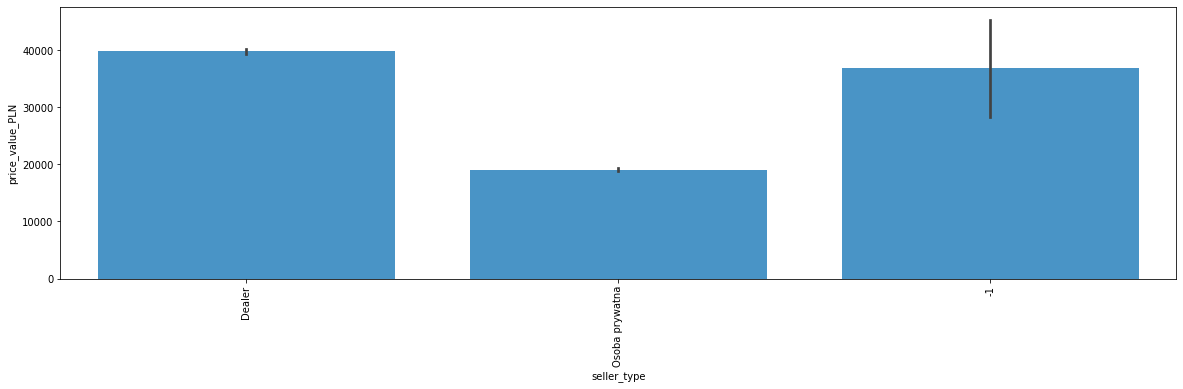

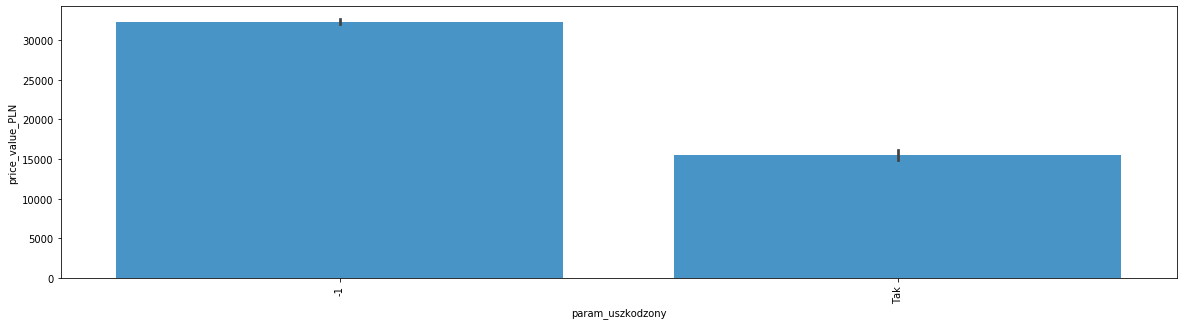

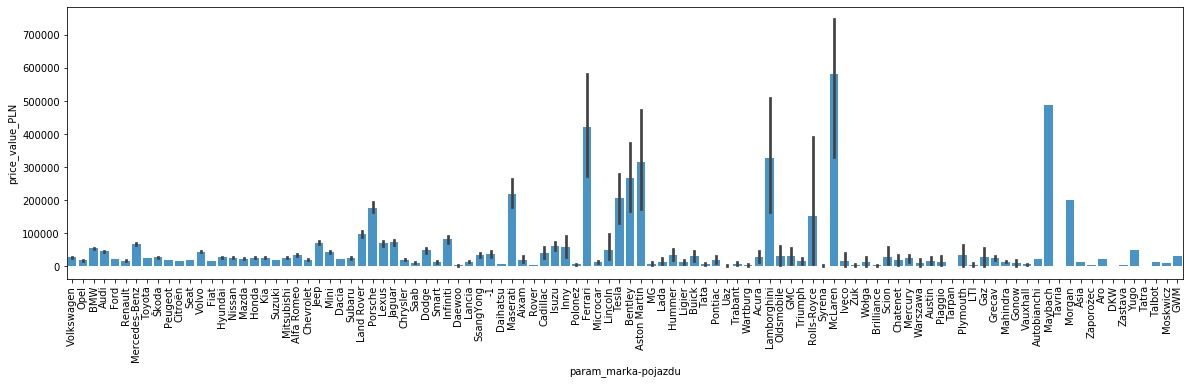

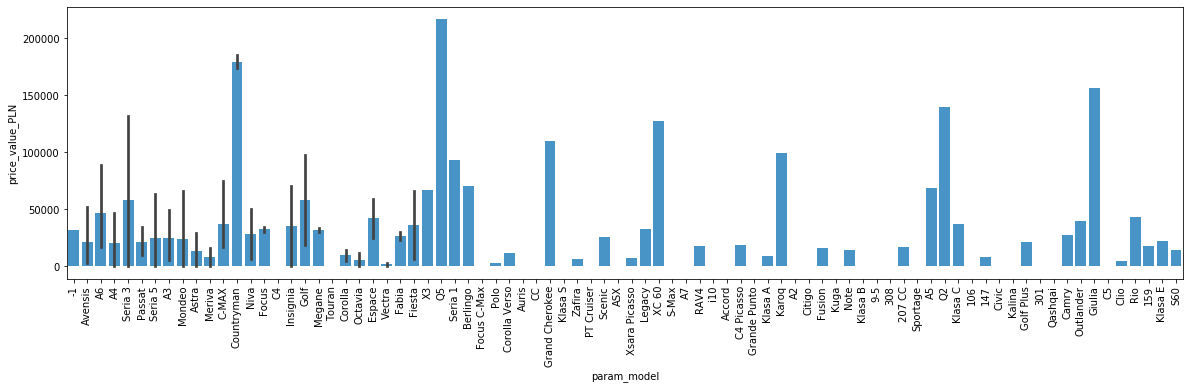

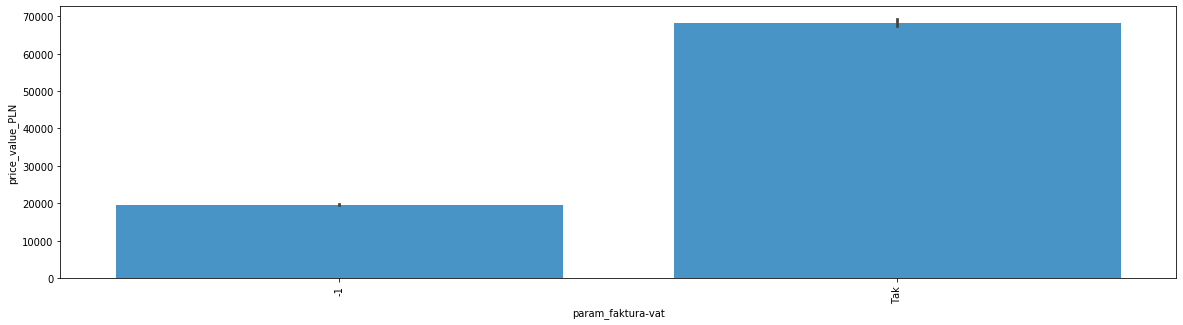

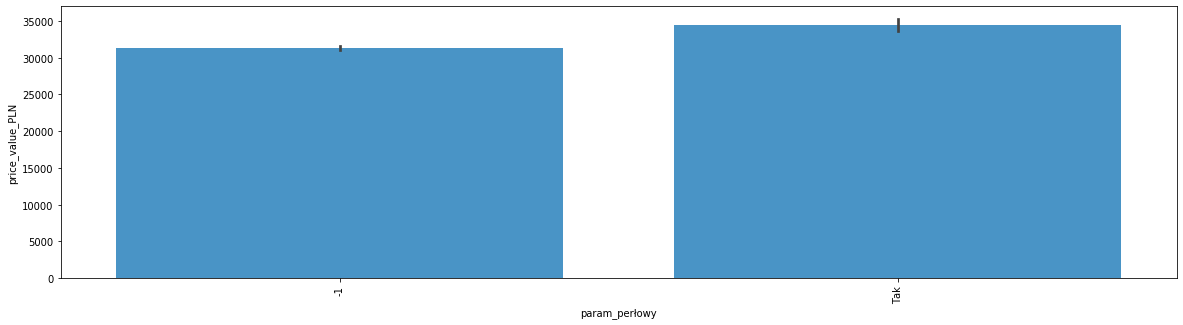

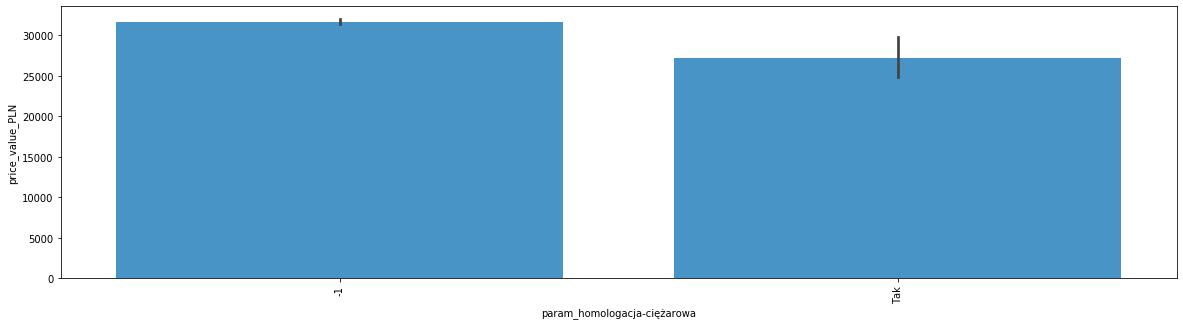

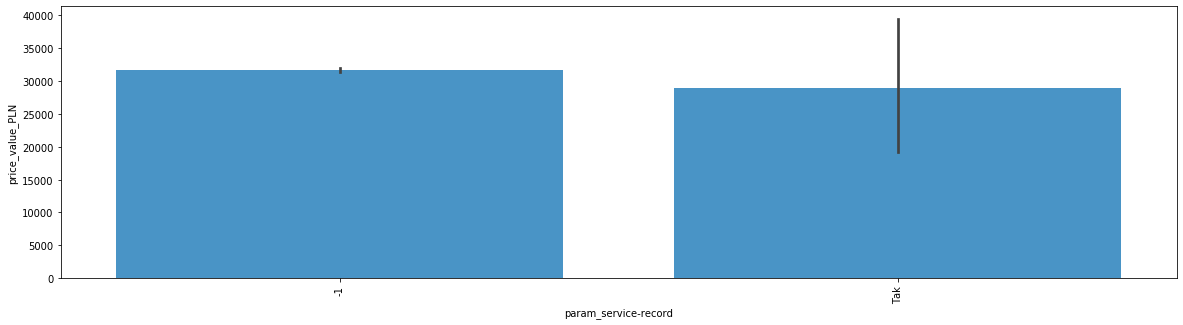

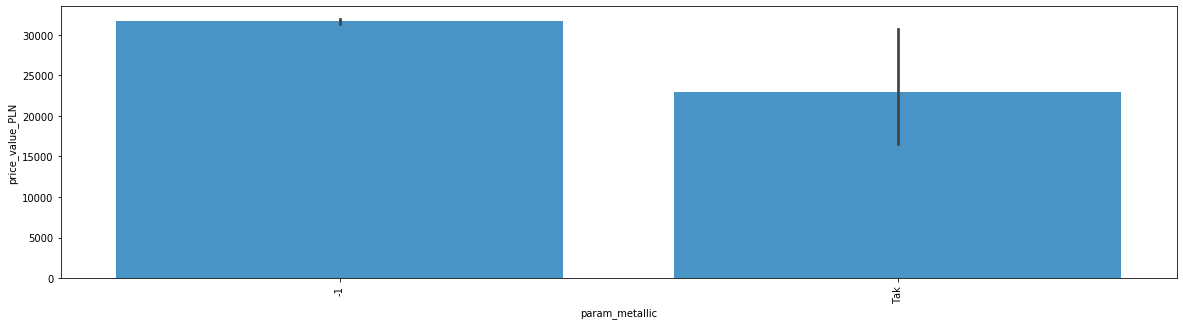

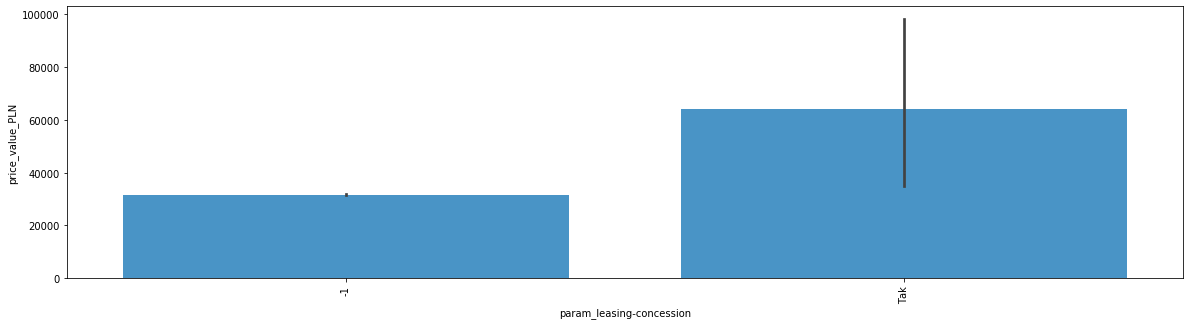

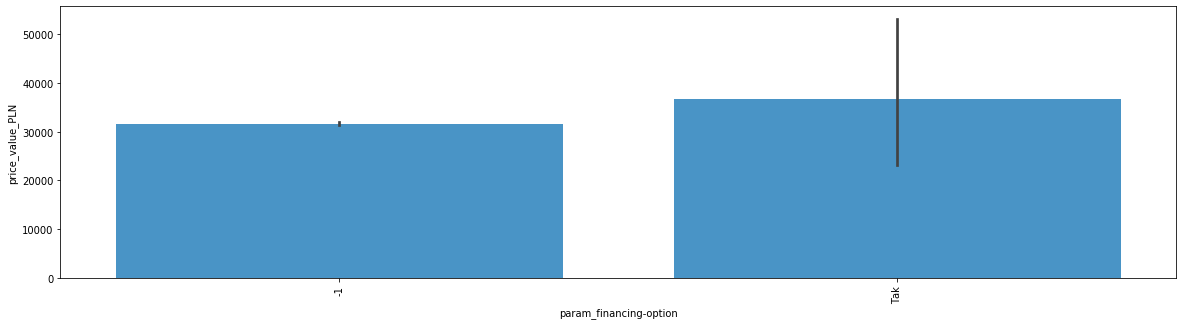

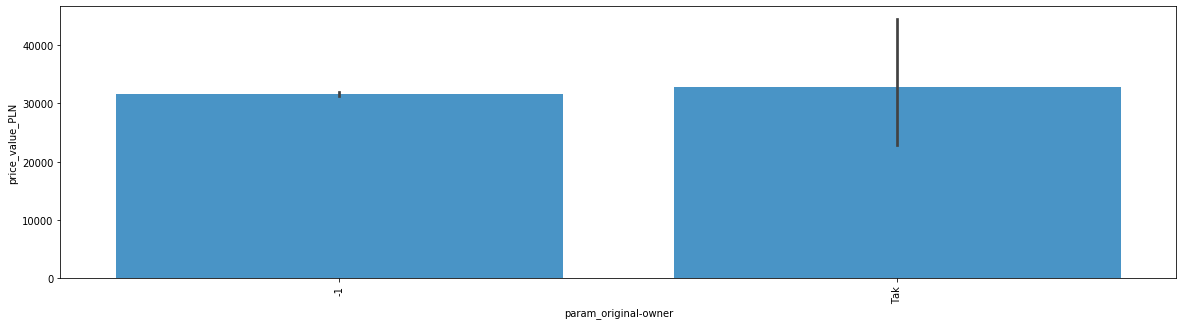

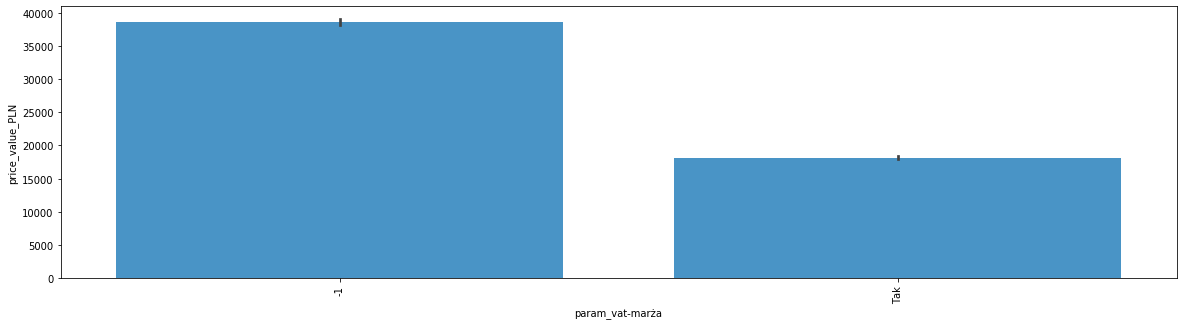

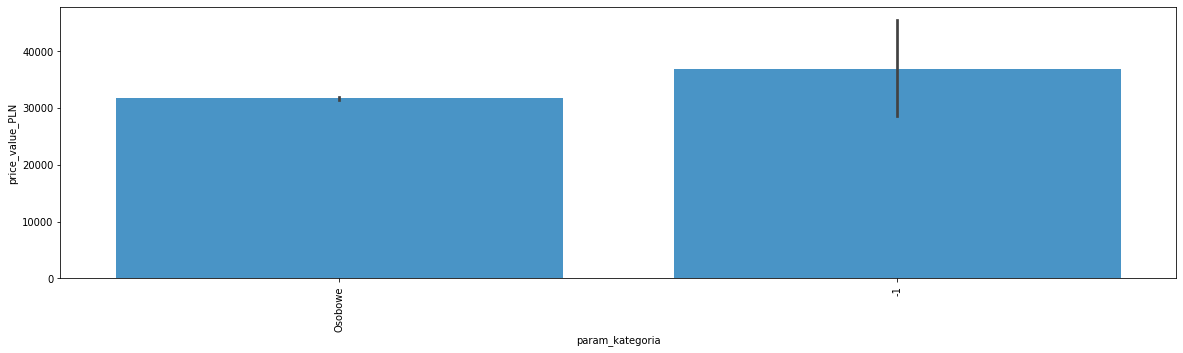

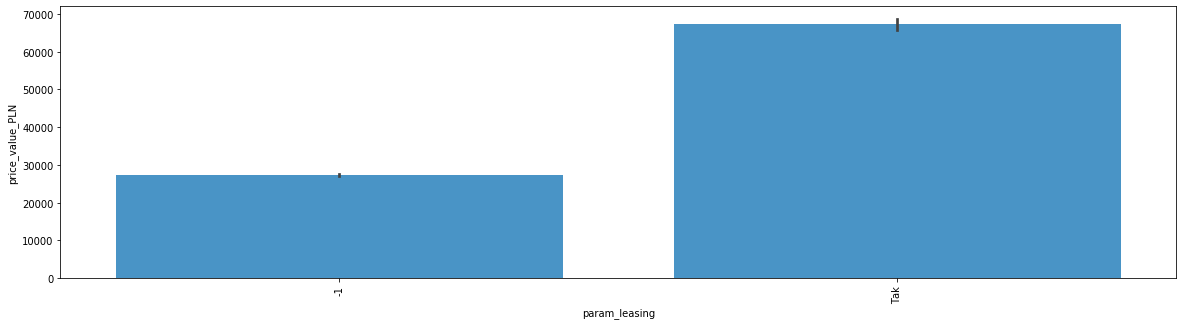

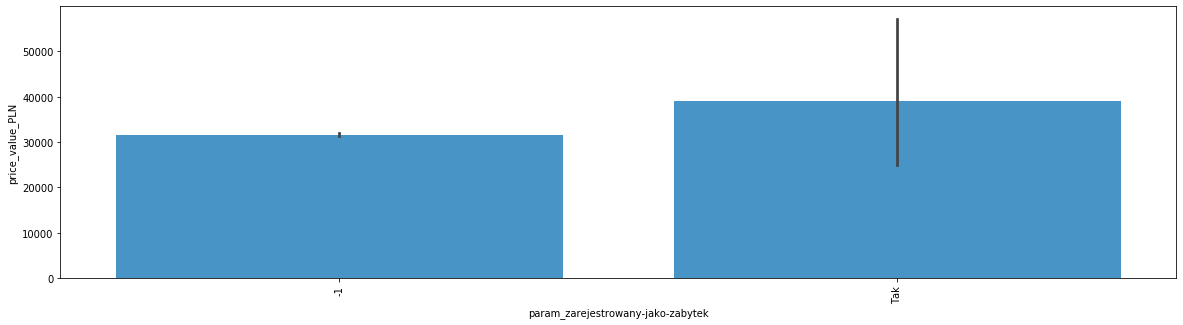

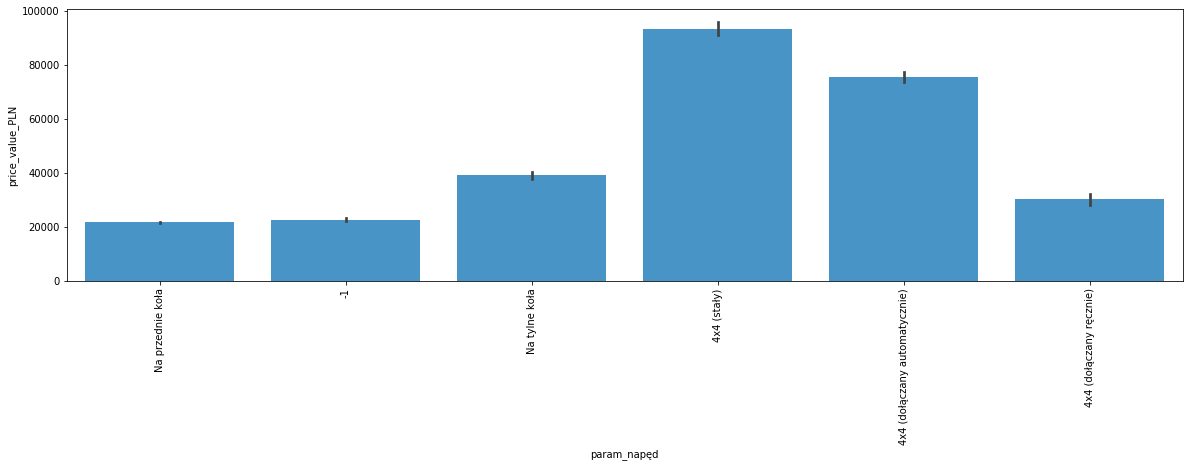

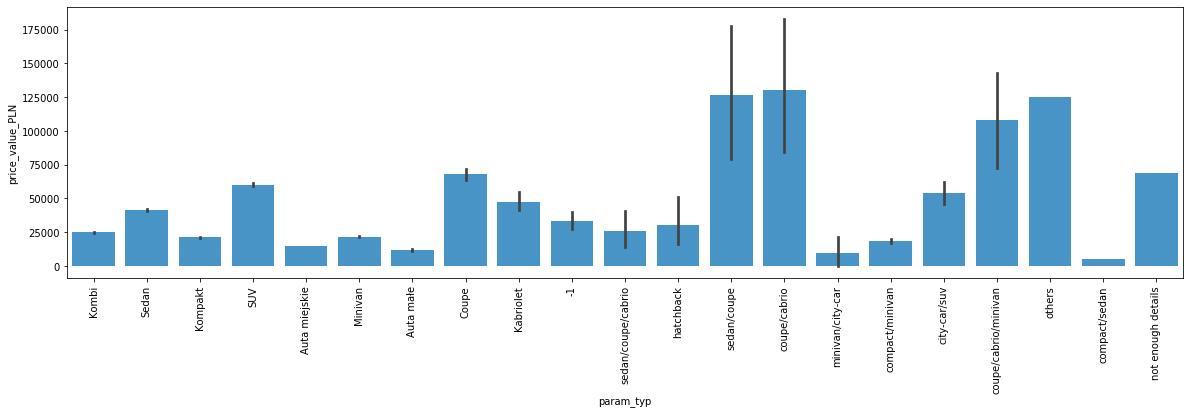

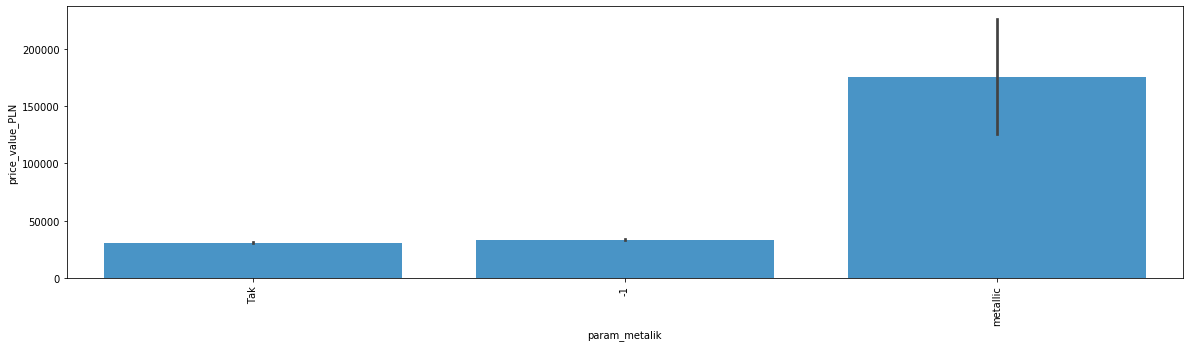

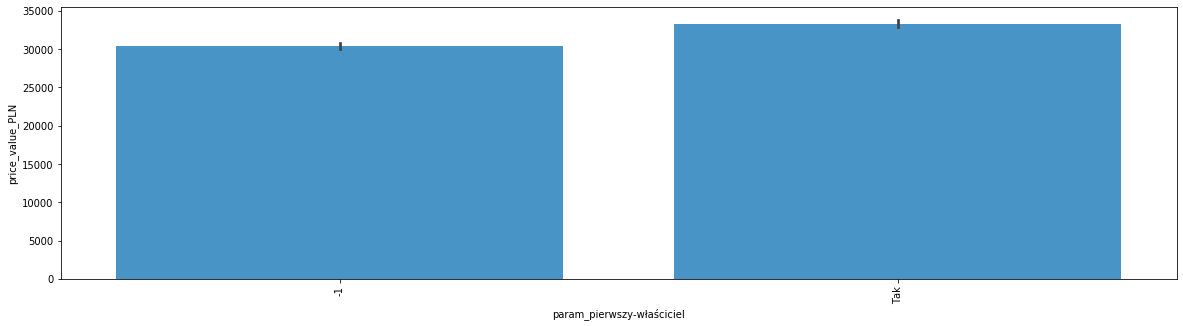

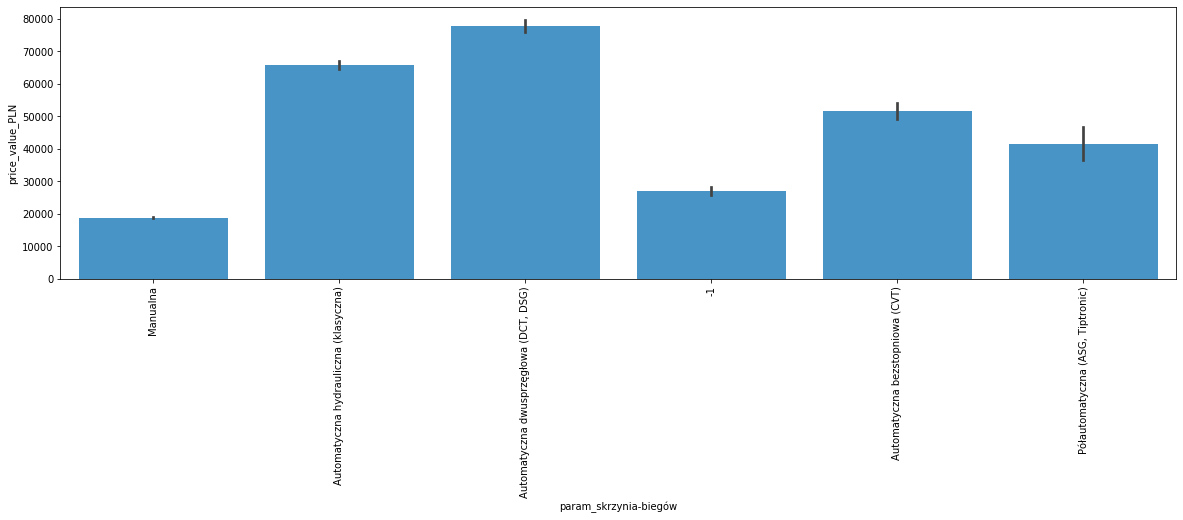

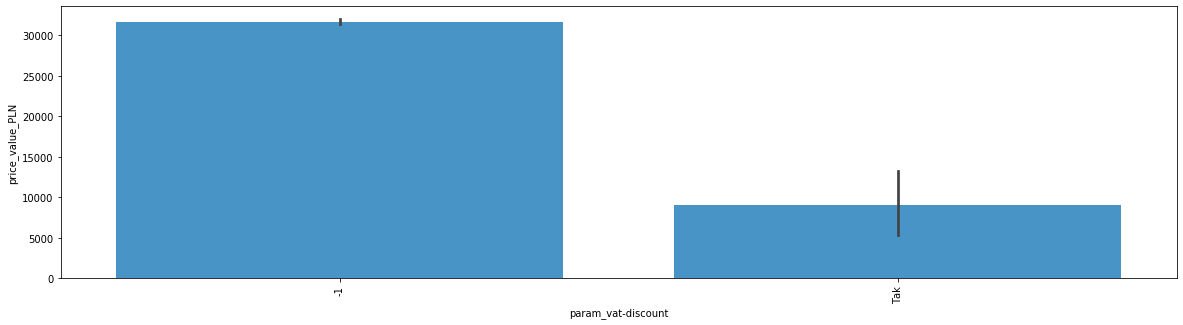

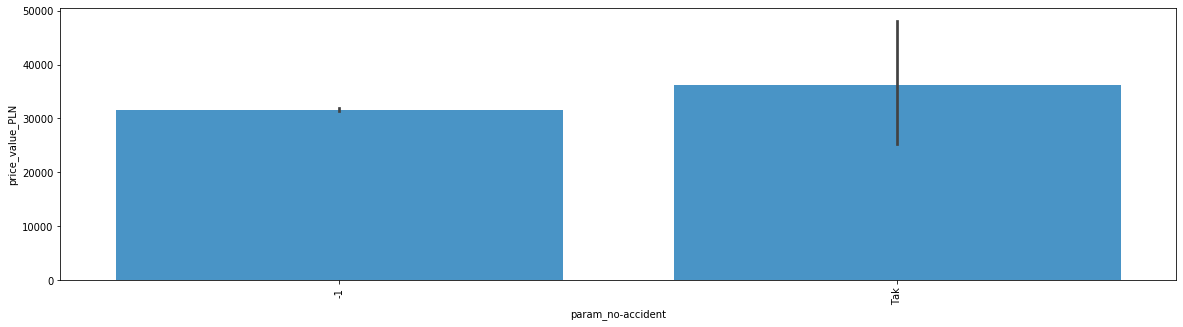

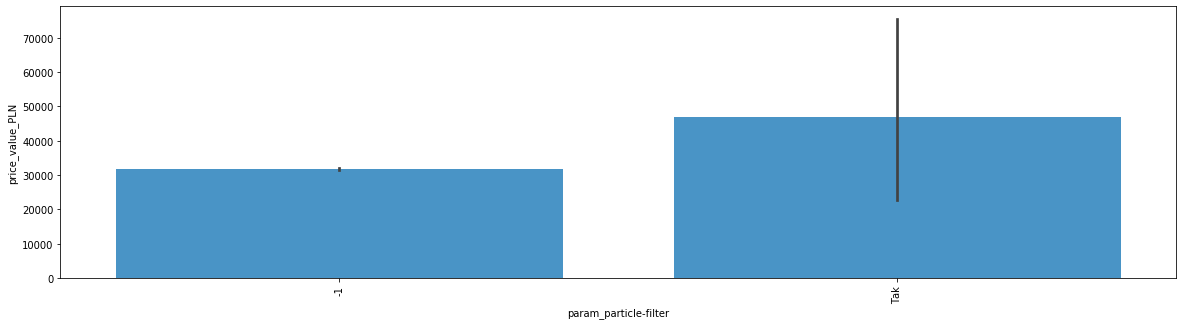

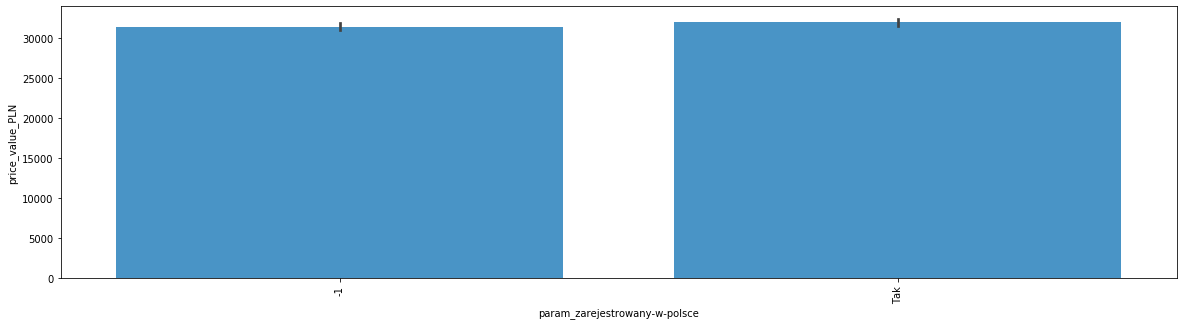

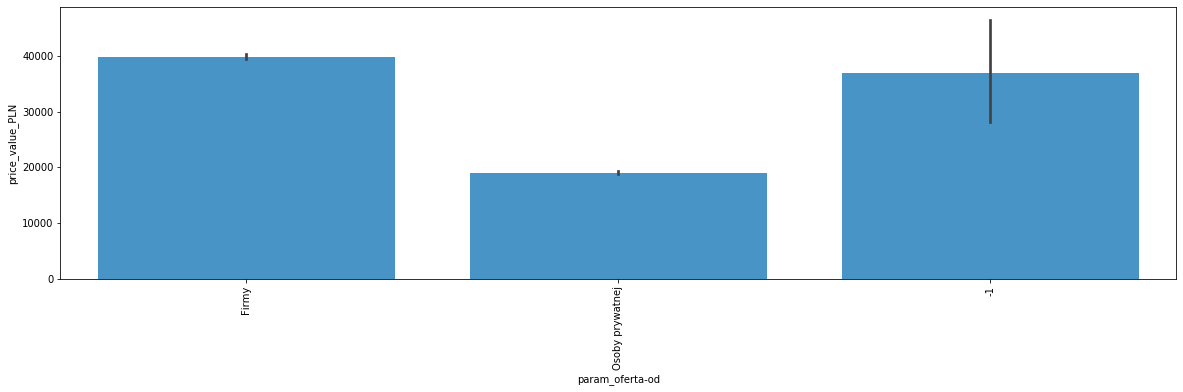

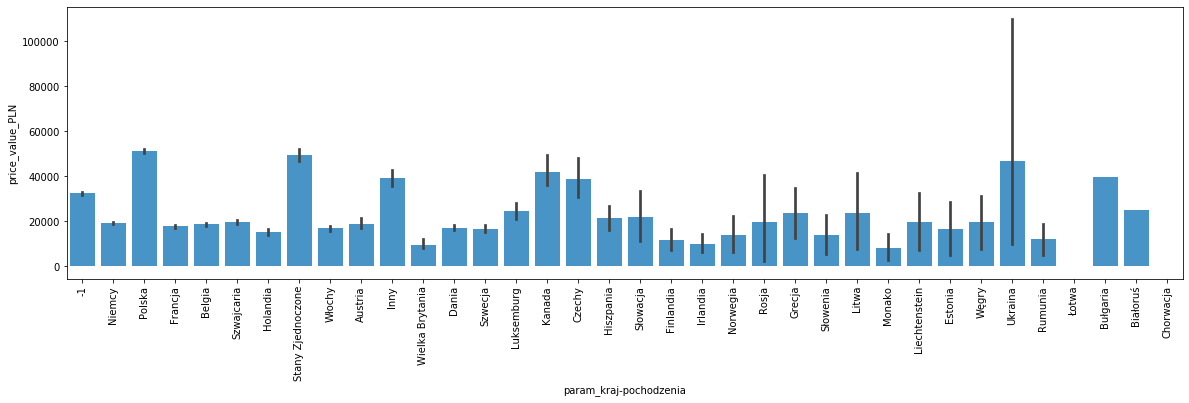

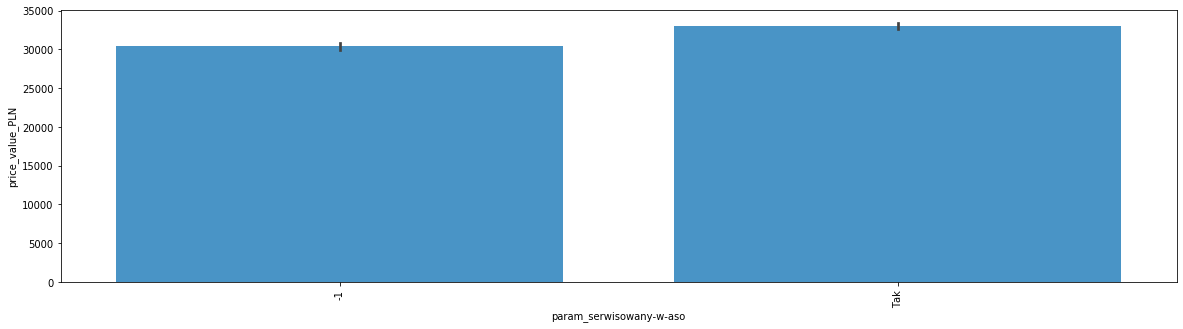

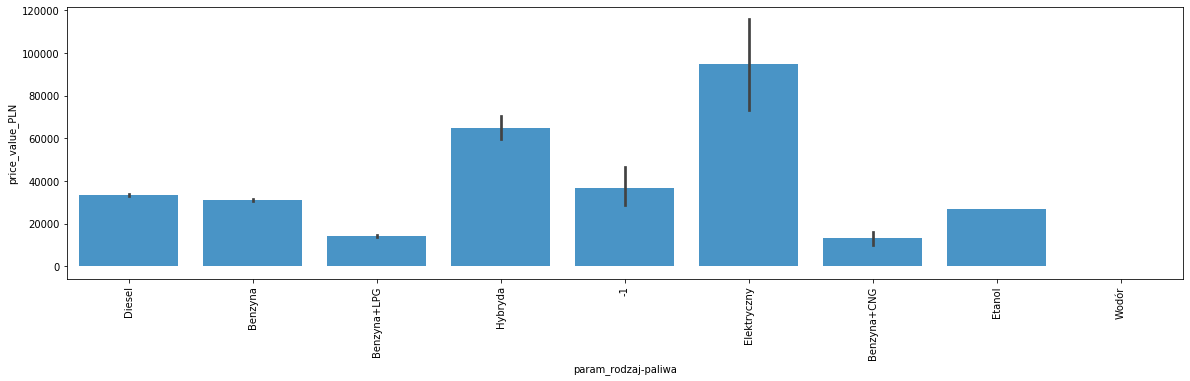

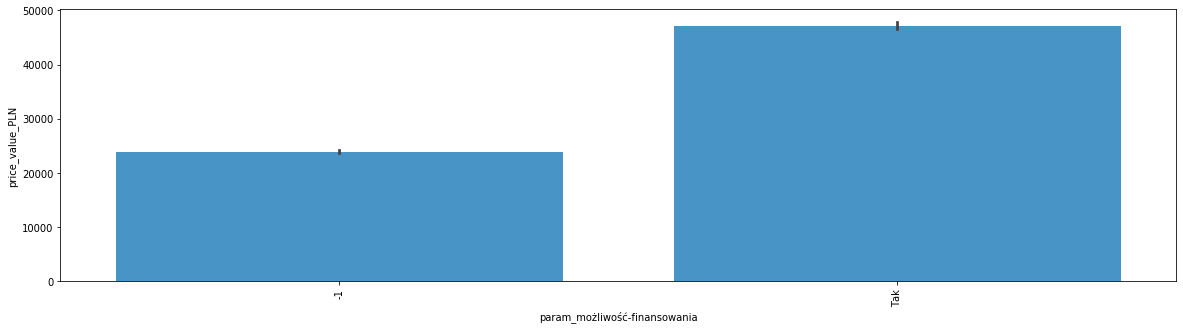

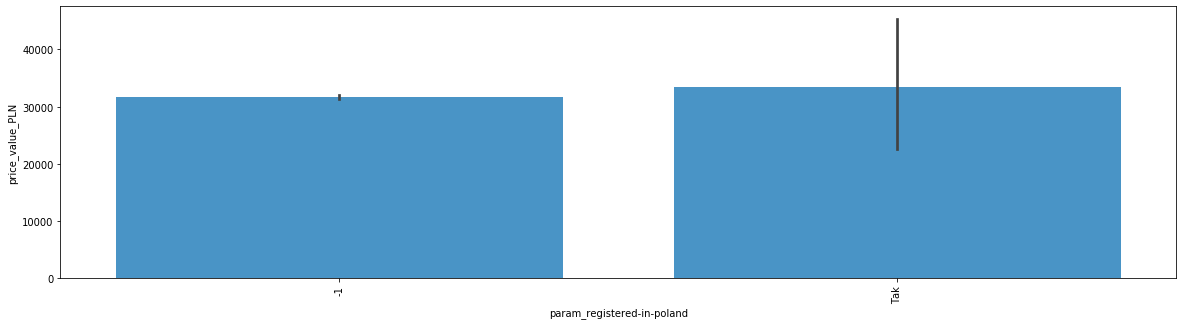

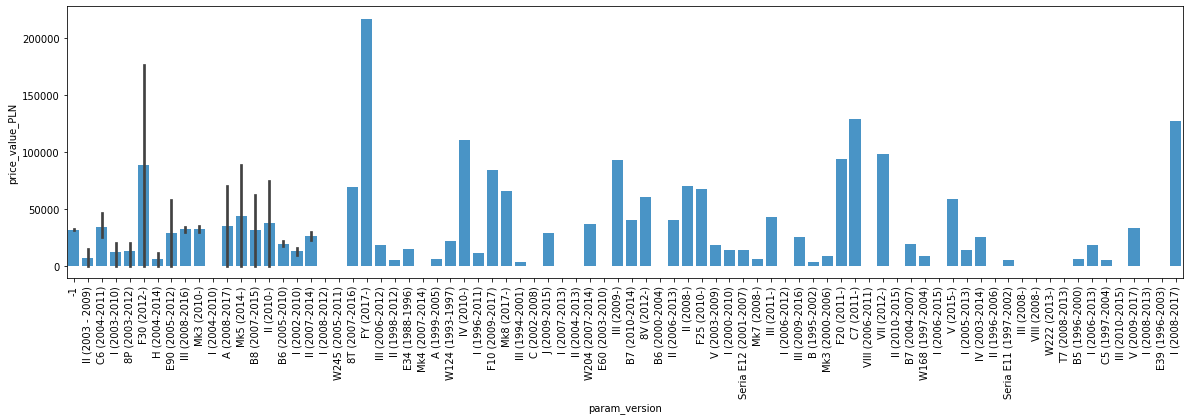

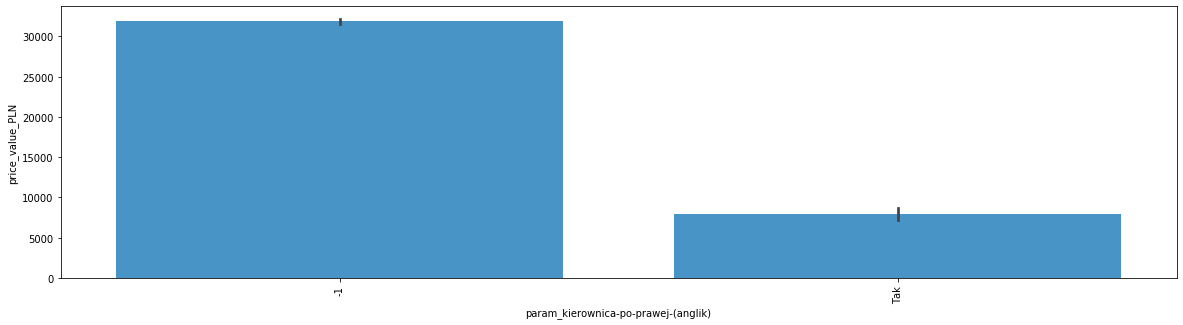

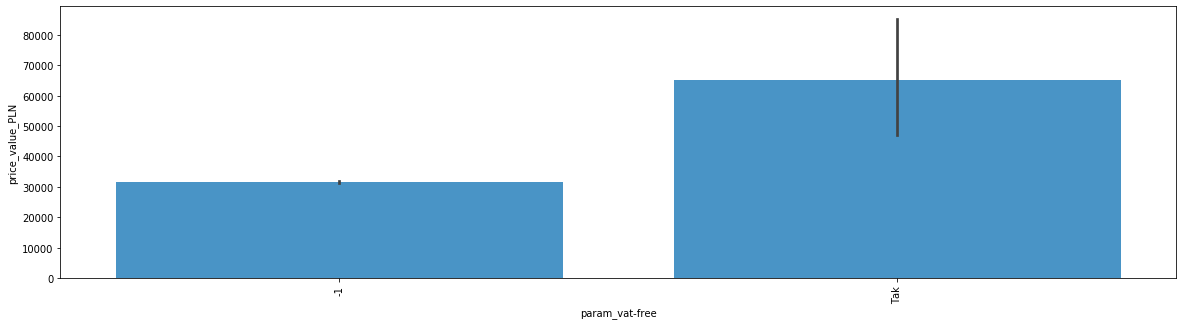

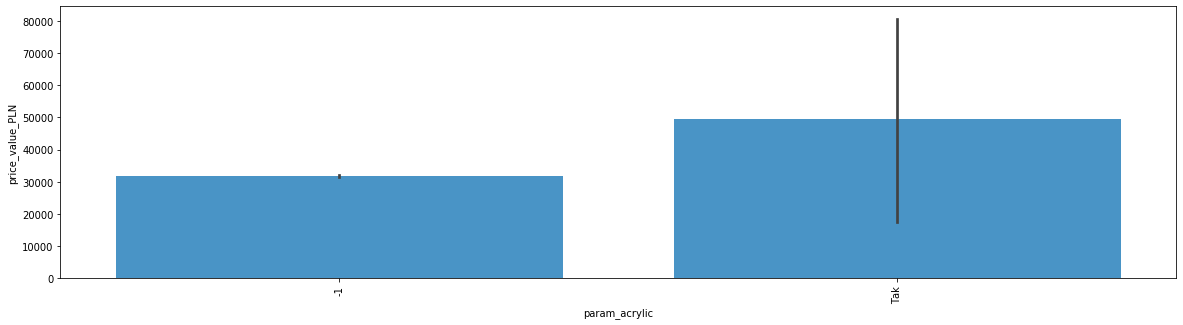

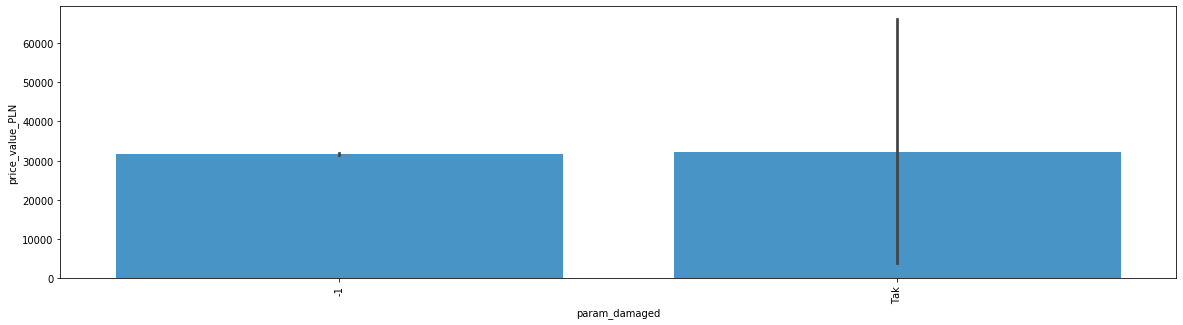

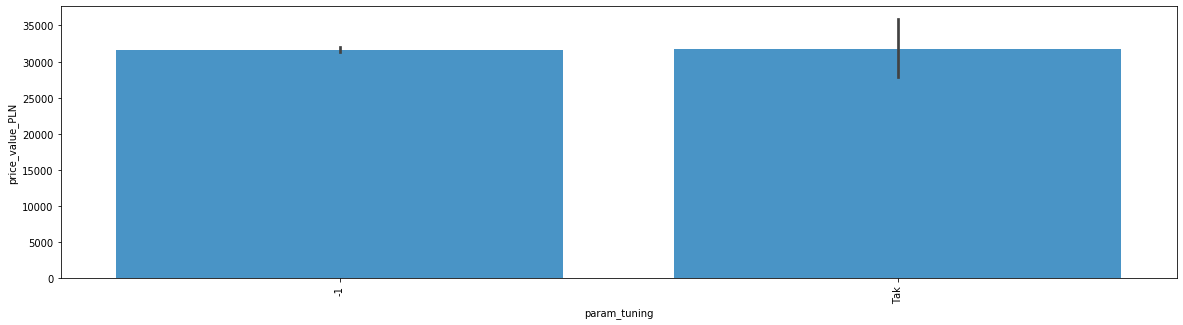

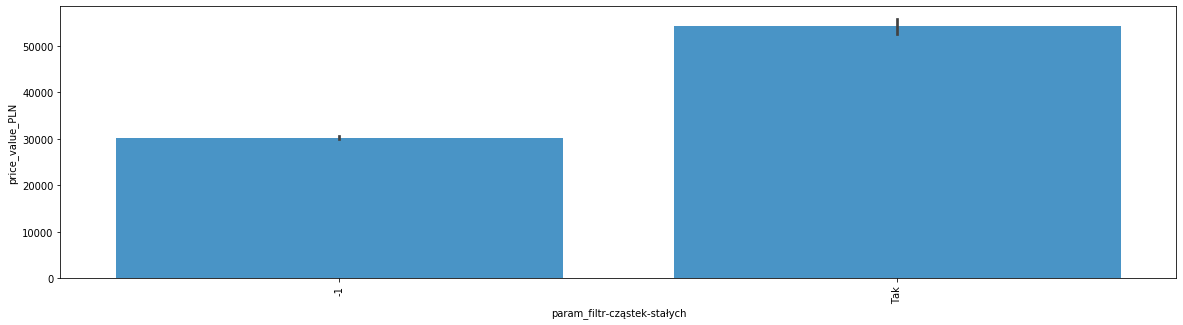

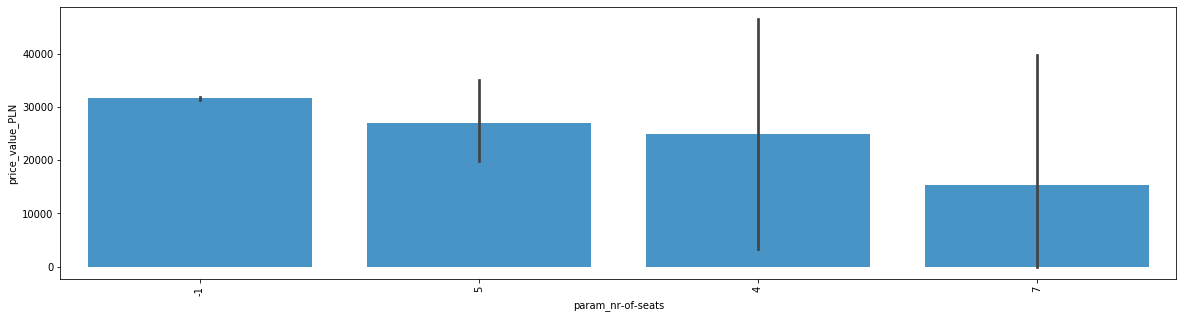

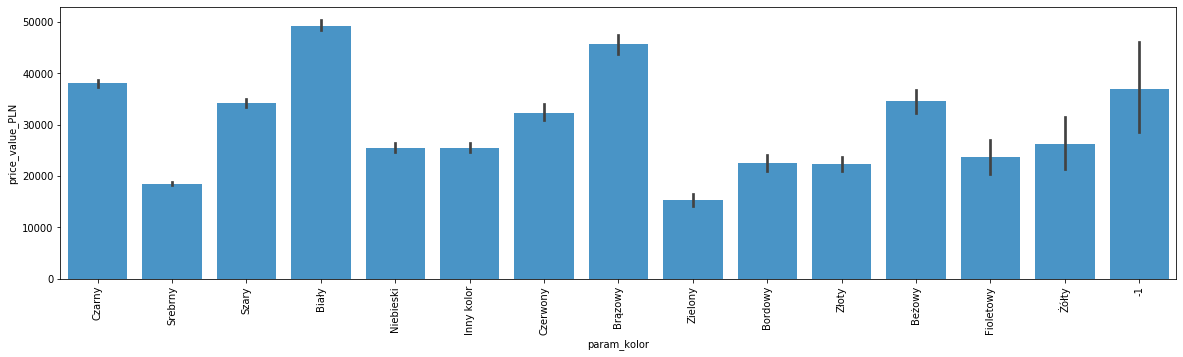

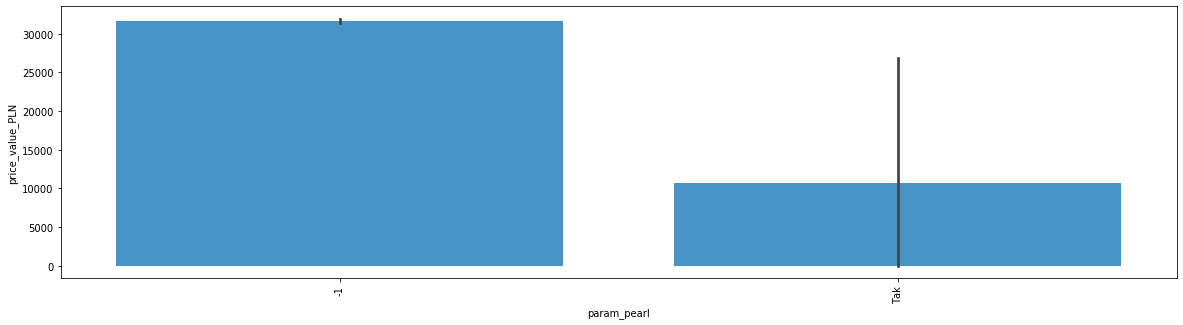

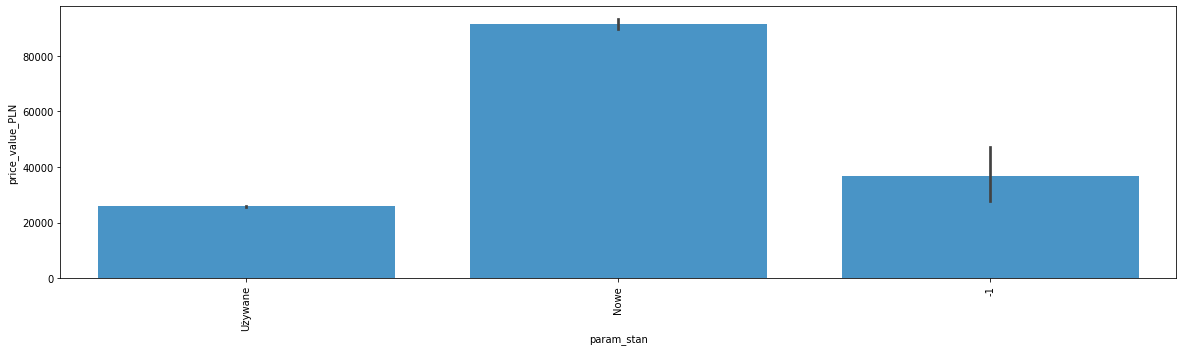

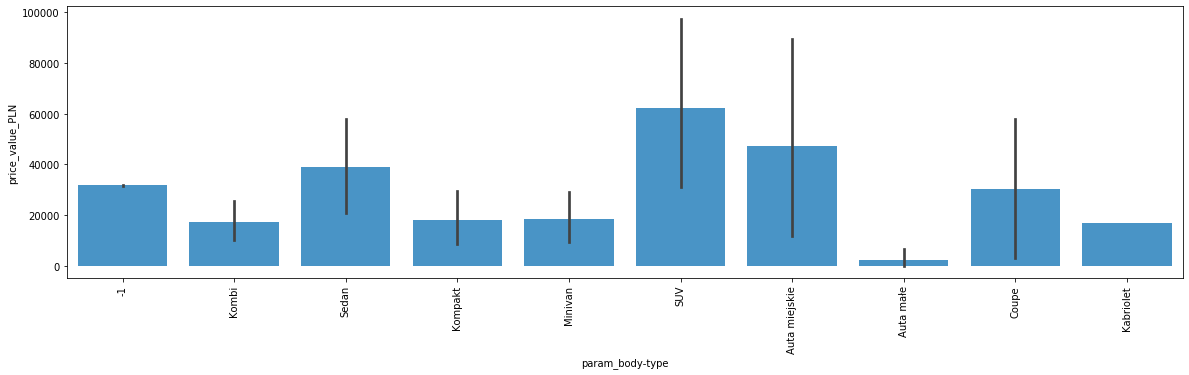

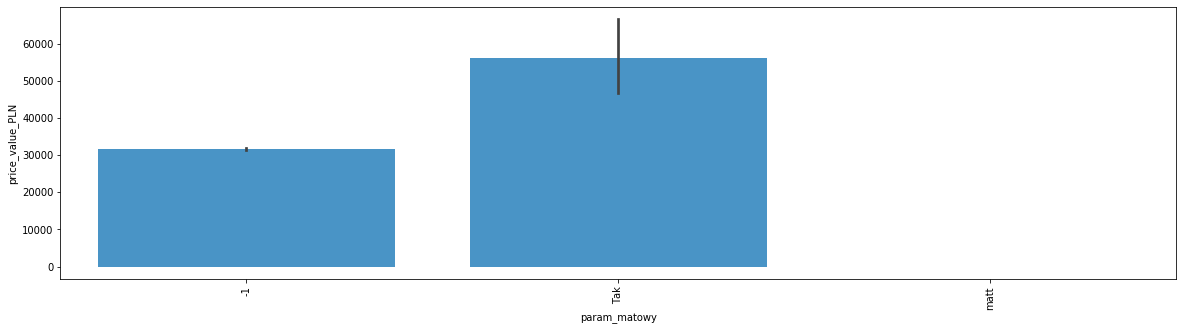

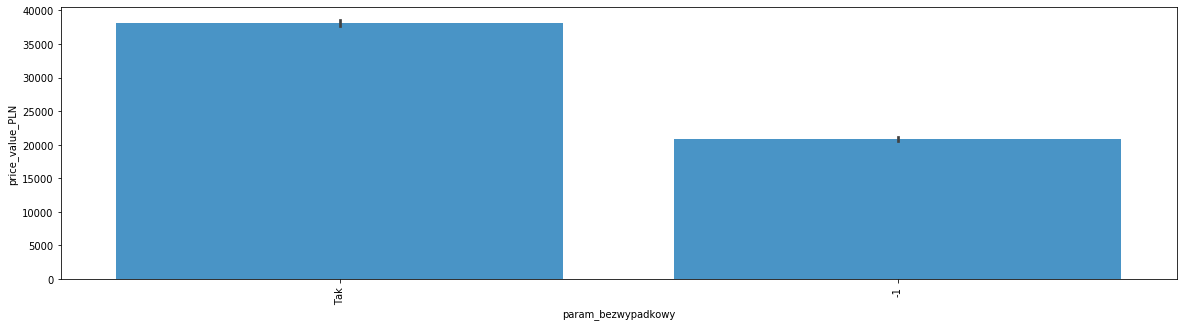

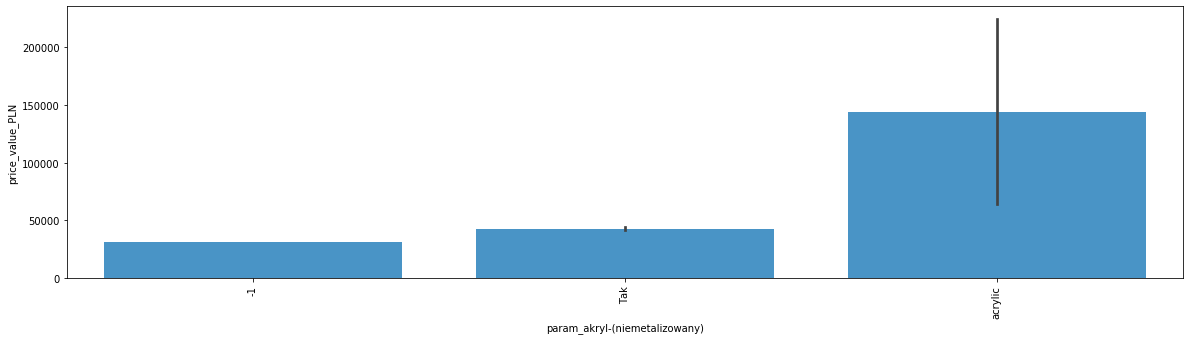

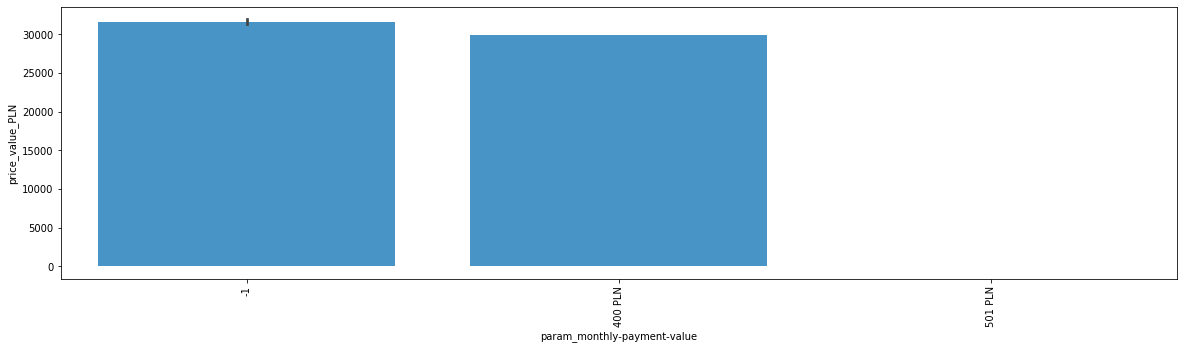

In [38]:
# categories are sorted by value_counts

cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat', 'param_wersja__cat', 'param_model-pojazdu__cat']

for cat_feat in cat_feats:
    if cat_feat not in cat_no_plot:
        cat_name = cat_feat[:-len(cat_feat_prefix)]
        plt.figure(figsize=(20,5))
        sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
        plt.xticks(rotation=90);
        plt.show()

###### numerical features

Numerical features had to be picked manually because they were originally stored as an object. They were stripped of units and spaces, so they can be stored and analized properly from now on.

In [39]:
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [40]:
df['param_moc'].sample(5)

56283        -1
84160    109 KM
4029     170 KM
17916     86 KM
87477    163 KM
Name: param_moc, dtype: object

In [41]:
def get_rid_of_unit_and_dec(val): # getting rid of units, spaces between numbers and decimals
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val


num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

# df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)

num_feats = [x for x in df.columns if num_feat_prefix in x]

To track progress made a model was trained using all prepared features. Score significantly improved.

In [42]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)
get_X_y_and_cros_val(df, model, feats, log=True)

(13997.826253074794, 35.86168756499662)

In [43]:
get_X_y_and_cros_val(df, model, feats, log=False)

(14509.849100314475, 234.38889941120422)

Going further it was logical to check if logarithmic 'long tale' features would improve the predictions in this instance. All 'long tale' numerical features were plotted as logarithmic to visualize if there is an improvement in feature symmetry.

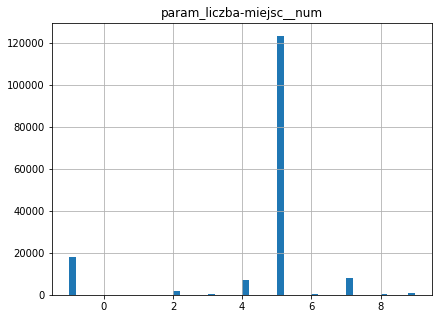

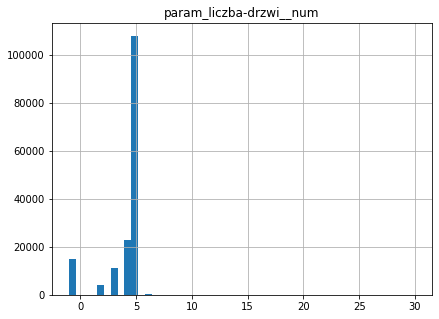

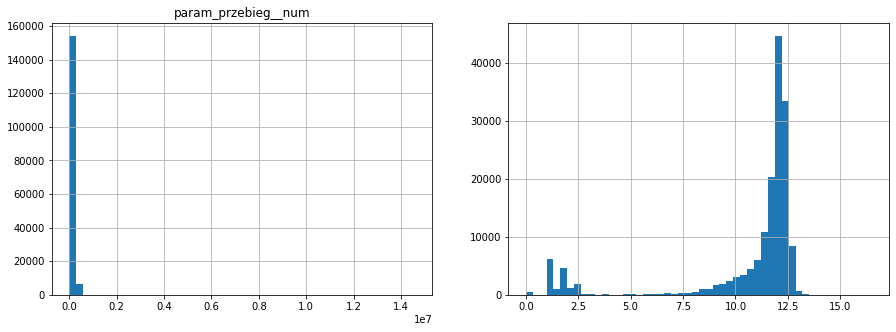

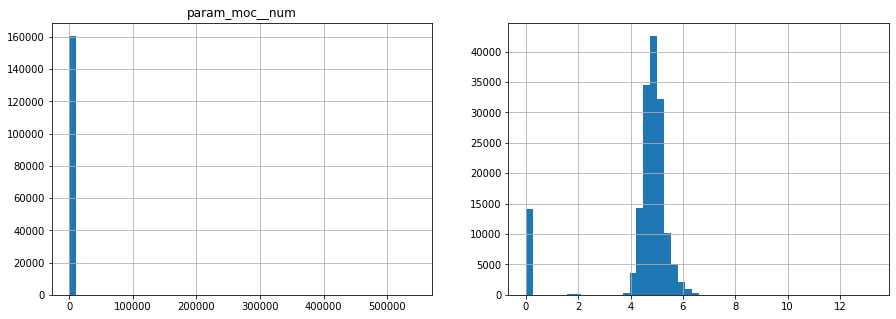

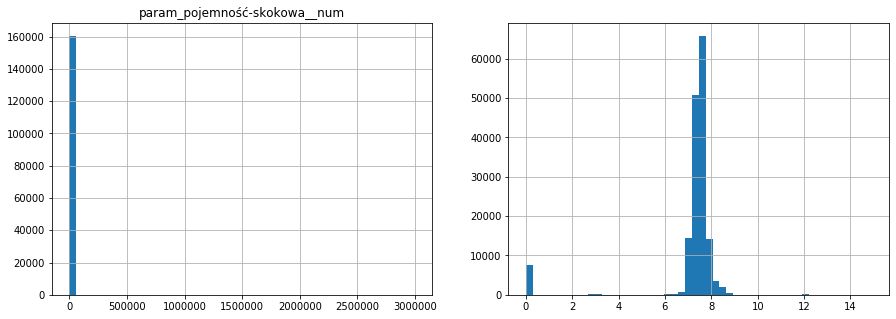

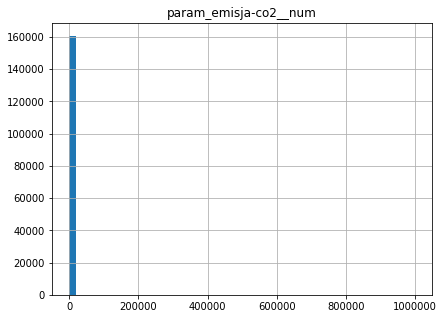

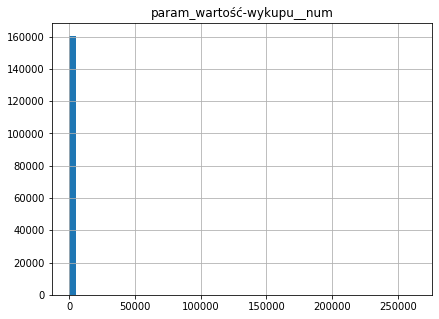

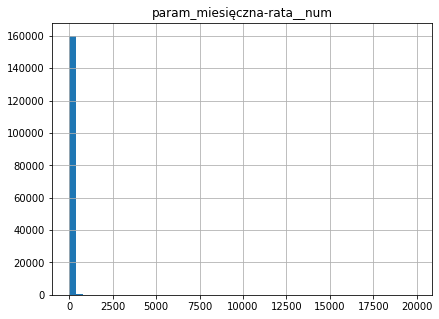

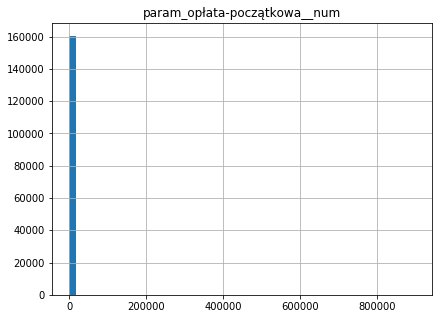

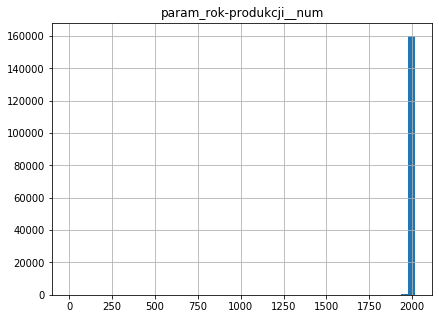

In [44]:
feats_to_log = ['param_przebieg__num', 'param_moc__num', 'param_pojemność-skokowa__num']

for feat in num_feats:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    df[feat].hist(bins=50)
    plt.title(feat)
    if feat in feats_to_log:
        plt.subplot(1,2,2)
        np.log1p(df[feat] + 1).hist(bins=50)    
    plt.show()

Features with 'long tale' characteristic were converted to logarithmic and added to features (while the non-logarithmic features were deducted from list). 

In [45]:
log_prefix = '__log'
for feat in feats_to_log:
    df[feat + log_prefix] = np.log1p(df[feat] + 1)
log_feats = [x for x in df.columns if log_prefix in x]
feats = feats + log_feats
feats = [x for x in feats if x + log_prefix not in log_feats]

In [46]:
feats

['feature_czujniki-parkowania-przednie',
 'feature_poduszka-powietrzna-chroniąca-kolana',
 'feature_kurtyny-powietrzne',
 'feature_klimatyzacja-dwustrefowa',
 'feature_światła-led',
 'feature_czujnik-zmierzchu',
 'feature_elektrycznie-ustawiane-lusterka',
 'feature_asr-(kontrola-trakcji)',
 'feature_poduszka-powietrzna-kierowcy',
 'feature_cd',
 'feature_elektryczne-szyby-przednie',
 'feature_poduszka-powietrzna-pasażera',
 'feature_system-start-stop',
 'feature_światła-do-jazdy-dziennej',
 'feature_komputer-pokładowy',
 'feature_elektryczne-szyby-tylne',
 'feature_klimatyzacja-manualna',
 'feature_tapicerka-welurowa',
 'feature_czujnik-deszczu',
 'feature_światła-przeciwmgielne',
 'feature_ogrzewanie-postojowe',
 'feature_radio-niefabryczne',
 'feature_regulowane-zawieszenie',
 'feature_ogranicznik-prędkości',
 'feature_zmieniarka-cd',
 'feature_szyberdach',
 'feature_isofix',
 'feature_asystent-pasa-ruchu',
 'feature_alufelgi',
 'feature_bluetooth',
 'feature_nawigacja-gps',
 'featur

As it is shown below logarithmic features improved the score, so they were kept in further calculations.

In [47]:
get_X_y_and_cros_val(df, model, feats, log=True)

(13996.567958424252, 36.889768077800426)

###### feature importance check

After each iteration of feature engineering feature importance was tracked to look for features worth working on in the next step.

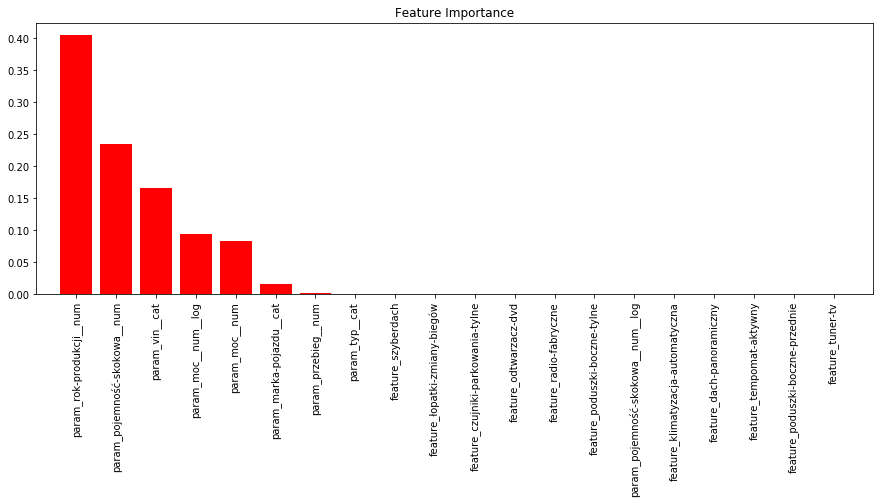

In [48]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats) + list(log_feats)

X = df[ feats ]
y = df['price_value_PLN']
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

To double check also Permutation Importance was verified since it is calculated differently then Feature Importance. Big differences between the two would need to be further investigated.

In [49]:
imp = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.5314 ± 0.0093,param_rok-produkcji__num
0.1888 ± 0.0090,param_pojemność-skokowa__num
0.1599 ± 0.0041,param_vin__cat
0.1128 ± 0.0017,param_moc__num__log
0.0689 ± 0.0005,param_moc__num
0.0089 ± 0.0005,param_marka-pojazdu__cat
0.0018 ± 0.0002,param_przebieg__num
0 ± 0.0000,feature_centralny-zamek
0 ± 0.0000,feature_łopatki-zmiany-biegów
0 ± 0.0000,feature_czujniki-parkowania-tylne


During error analysis in the end it came out that biggest error is generated by luxury car brands so an additional boolean feature 'luxury_car' was created.

In [50]:
luxury_car_brands = ['McLaren', 'Ferrari', 'Aston Martin', 'Lamborghini', 'Bentley', 'Rolls-Royce', 'Morgan']
df['luxury_car'] = df['param_marka-pojazdu'].map(lambda x: True if x in luxury_car_brands else False)
bool_feats = list(bool_feats)
if 'luxury_car' not in bool_feats: bool_feats.append('luxury_car')

# Preparing test train set

After feature engineering data frame was divided back into train and test set.

In [51]:
df[ df['price_value_PLN'] == -1 ].shape

(54122, 213)

In [52]:
train = df[ df['price_value_PLN'] != -1].reset_index(drop=True)
test = df[ df['price_value_PLN'] == -1 ].reset_index(drop=True)

del df

print(train.shape)
print(test.shape)

(106494, 213)
(54122, 213)


In [53]:
train.head(1)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,param_zare

# Model selection and optimization

Functions below were created to test various models. All were tested on the same test of features.

In [55]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats) + list(log_feats)
feats = [x for x in feats if x + log_prefix not in feats]

def get_X_y(feats):
    return train[ feats ].values, train['price_value_PLN'].values

#plots feature importance, learning curve and permutation importance
def plot_fi_lc_e5(model, feats, pi=True, lc=True, e5=False):
    X, y = get_X_y(feats)
    model.fit(X, y)
    
    if pi:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    if lc:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');
    if e5:
        imp = PermutationImportance(model, random_state=0).fit(X,y)
        return eli5.show_weights(imp, feature_names=feats)

# returns list of most important features in particular model
def get_model_importance(model, feats):
    X, y = get_X_y(feats)
    model.fit(X, y)
    importances = model.feature_importances_
    m_imp = [(feats[idx], importances[idx]) for idx in range(len(feats))]
    return sorted(m_imp, key=lambda x: x[1], reverse=True)

Scores and feature importance was checked for few different models.

In [56]:
# Testing Decision Tree
model = DecisionTreeRegressor(max_depth=10)
get_X_y_and_cros_val(train, model, feats, log=True)

(10547.540267444036, 92.40163049630401)

In [57]:
# Testing Random Forest
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
get_X_y_and_cros_val(train, model, feats, log=True)

(9292.40439072474, 29.0626807236354)

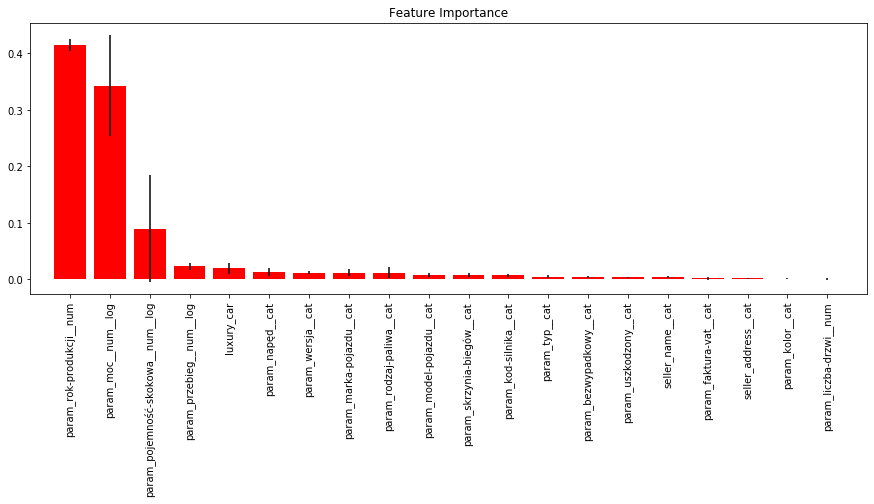

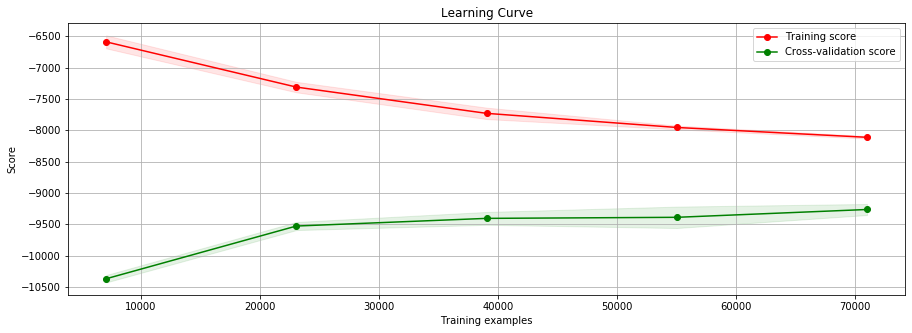

In [58]:
plot_fi_lc_e5(model, feats, True, True, False)

In [59]:
# testing XGB regressor
xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

model = XGBRegressor(**xgb_params)
get_X_y_and_cros_val(train, model, feats, log=True)

(7903.896196847567, 59.02367284760159)

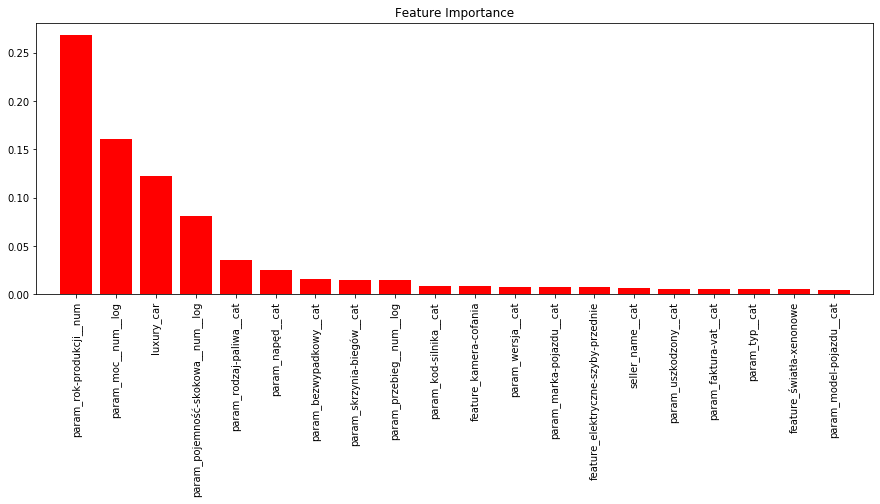

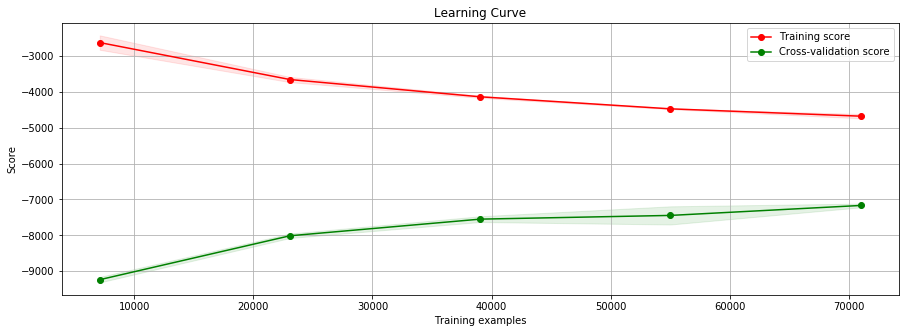

In [60]:
plot_fi_lc_e5(model, feats, True, True, False)

Additionally the hyperparameter of the XGB regressor were optimized using fmin function.

In [52]:
# Since XBG looks most promising it gets hyper optimized

def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'seed':0
    }

    print('training wiht params: {}'.format(xgb_params))
    model = XGBRegressor(**xgb_params)
    score = get_X_y_and_cros_val(train, model, feats, log=True)[0]
    
    print('score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

training wiht params: {'max_depth': 2, 'learning_rate': 0.26744967551230975, 'colsample_bytree': 0.9228479274978695, 'subsample': 0.7146951897677682, 'min_child_weight': 10, 'n_estimators': 100, 'seed': 0}
score: 9561.26082792929                               

training wiht params: {'max_depth': 5, 'learning_rate': 0.07093783033769126, 'colsample_bytree': 0.8914728220066465, 'subsample': 0.773498517539175, 'min_child_weight': 8, 'n_estimators': 100, 'seed': 0}
score: 8525.204761217015                                                      

training wiht params: {'max_depth': 5, 'learning_rate': 0.10663314993765168, 'colsample_bytree': 0.8898110660712557, 'subsample': 0.9615390254654081, 'min_child_weight': 10, 'n_estimators': 100, 'seed': 0}
score: 8076.7948160840315                                                      

training wiht params: {'max_depth': 7, 'learning_rate': 0.10615410857040013, 'colsample_bytree': 0.9993469590535049, 'subsample': 0.9627025646273258, 'min_child_weight

score: 6504.997278188977                                                        

training wiht params: {'max_depth': 16, 'learning_rate': 0.24333941106957357, 'colsample_bytree': 0.9697458407620743, 'subsample': 0.8712112180720972, 'min_child_weight': 8, 'n_estimators': 100, 'seed': 0}
score: 6831.05119095375                                                         

training wiht params: {'max_depth': 11, 'learning_rate': 0.08901820109202369, 'colsample_bytree': 0.8950896667907893, 'subsample': 0.8039206765767526, 'min_child_weight': 3, 'n_estimators': 100, 'seed': 0}
score: 6675.3523175993005                                                       

training wiht params: {'max_depth': 9, 'learning_rate': 0.16010975496160265, 'colsample_bytree': 0.9053183415855017, 'subsample': 0.949991701797314, 'min_child_weight': 8, 'n_estimators': 100, 'seed': 0}
score: 6726.290615083229                                                        

training wiht params: {'max_depth': 19, 'learning_rate':

After hyperoptimization new hyperparameters were checked:

In [61]:
xgb_params_opt = {'colsample_bytree': 0.8654981994048777,
                  'learning_rate': 0.12571720240116988,
                  'max_depth': 16,
                  'min_child_weight': 4,
                  'subsample': 0.9259772117160755,
                  'n_estimators': 100, 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params_opt)

In [62]:
get_X_y_and_cros_val(train, model, feats, log=True)

(6405.043610822832, 103.13253775392464)

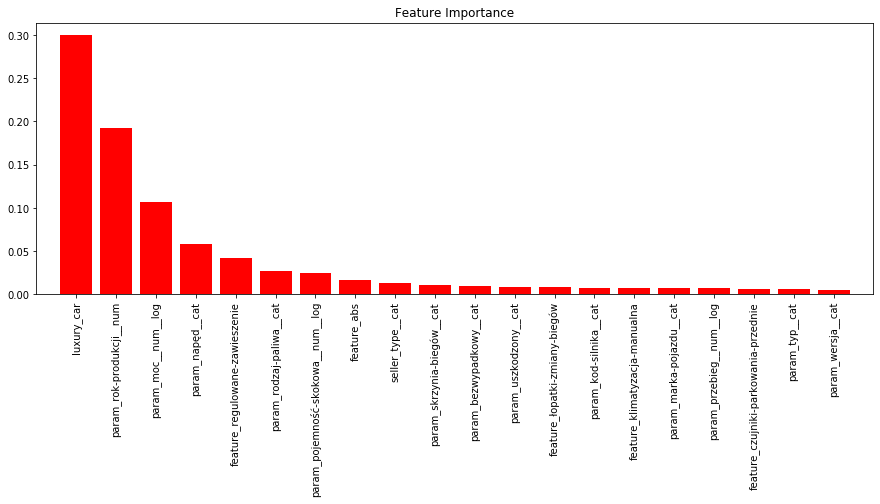

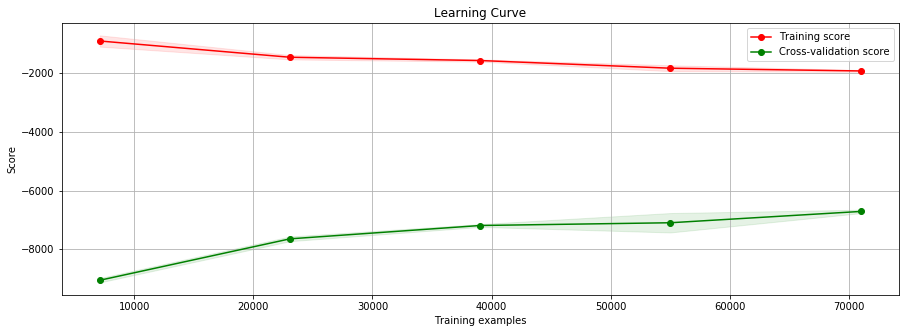

In [63]:
plot_fi_lc_e5(model, feats, True, True, False)

Model seems to be a bit over fitted so parameters were changed to:

In [64]:
xgb_params = {'colsample_bytree': 0.8,
                  'learning_rate': 0.1,
                  'max_depth': 10,
                  'min_child_weight': 4,
                  'subsample': 0.8,
                  'n_estimators': 100, 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params)
get_X_y_and_cros_val(train, model, feats, log=True)

(6827.077111441486, 91.11597717359807)

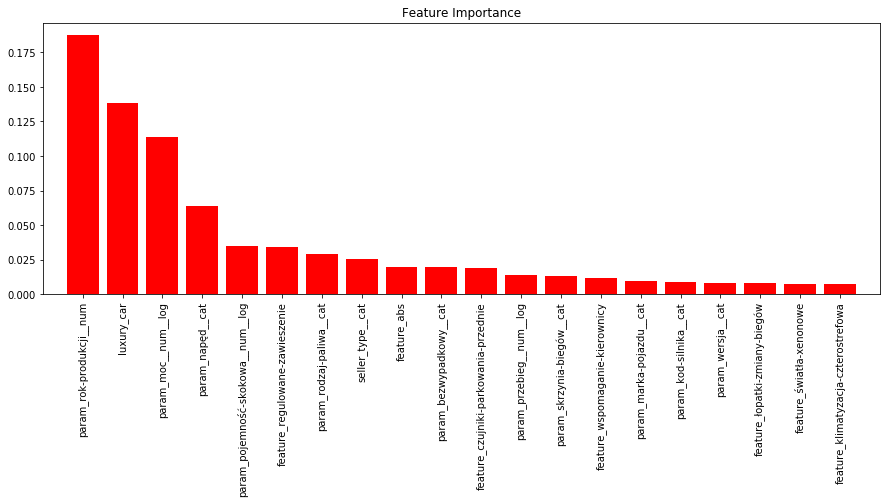

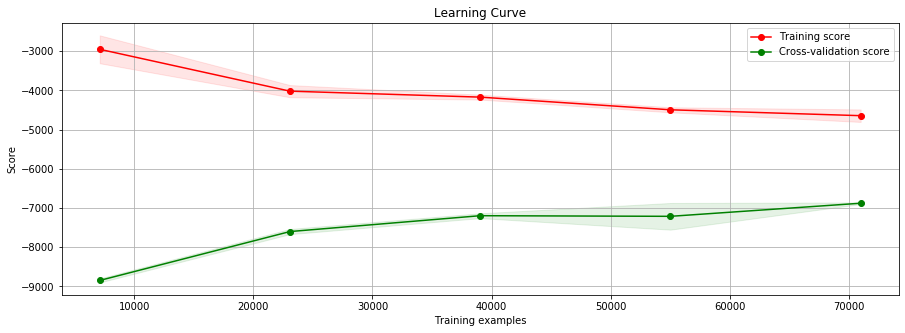

In [65]:
plot_fi_lc_e5(model, feats, True, True, False)

Also model feature importance was checked to finally decide which features are relewant.

In [66]:
get_model_importance(model, feats)

[('param_rok-produkcji__num', 0.18720305),
 ('luxury_car', 0.13824846),
 ('param_moc__num__log', 0.113801286),
 ('param_napęd__cat', 0.063675165),
 ('param_pojemność-skokowa__num__log', 0.034959745),
 ('feature_regulowane-zawieszenie', 0.034077305),
 ('param_rodzaj-paliwa__cat', 0.029096989),
 ('seller_type__cat', 0.025484968),
 ('feature_abs', 0.019949218),
 ('param_bezwypadkowy__cat', 0.019743618),
 ('feature_czujniki-parkowania-przednie', 0.018661179),
 ('param_przebieg__num__log', 0.01374672),
 ('param_skrzynia-biegów__cat', 0.013396887),
 ('feature_wspomaganie-kierownicy', 0.011552421),
 ('param_marka-pojazdu__cat', 0.009333876),
 ('param_kod-silnika__cat', 0.009041946),
 ('param_wersja__cat', 0.00828032),
 ('feature_łopatki-zmiany-biegów', 0.007977381),
 ('feature_światła-xenonowe', 0.00760101),
 ('feature_klimatyzacja-czterostrefowa', 0.007212185),
 ('param_faktura-vat__cat', 0.0069054402),
 ('param_typ__cat', 0.0069038095),
 ('feature_kamera-cofania', 0.006775423),
 ('param_usz

In [67]:
less_feats = [ x[0] for x in get_model_importance(model, feats) if x[1] > 0.0040 ]
less_feats

['param_rok-produkcji__num',
 'luxury_car',
 'param_moc__num__log',
 'param_napęd__cat',
 'param_pojemność-skokowa__num__log',
 'feature_regulowane-zawieszenie',
 'param_rodzaj-paliwa__cat',
 'seller_type__cat',
 'feature_abs',
 'param_bezwypadkowy__cat',
 'feature_czujniki-parkowania-przednie',
 'param_przebieg__num__log',
 'param_skrzynia-biegów__cat',
 'feature_wspomaganie-kierownicy',
 'param_marka-pojazdu__cat',
 'param_kod-silnika__cat',
 'param_wersja__cat',
 'feature_łopatki-zmiany-biegów',
 'feature_światła-xenonowe',
 'feature_klimatyzacja-czterostrefowa',
 'param_faktura-vat__cat',
 'param_typ__cat',
 'feature_kamera-cofania',
 'param_uszkodzony__cat',
 'feature_alufelgi',
 'param_model-pojazdu__cat',
 'feature_elektrycznie-ustawiane-fotele',
 'feature_elektryczne-szyby-przednie',
 'param_oferta-od__cat',
 'param_stan__cat',
 'feature_nawigacja-gps',
 'feature_tapicerka-skórzana']

In [68]:
print(len(less_feats))
model = XGBRegressor(**xgb_params)
get_X_y_and_cros_val(train, model, feats, log=True)

32


(6827.077111441486, 91.11597717359807)

# Error analysis

During this project on various occasions model error was analysed. To do so error was calculated per record. 

In [69]:
X, y = get_X_y(feats)

y_pred = cross_val_predict(model, X, y, cv=3)
train['pred'] = y_pred
train['error'] = train[['pred', 'price_value_PLN']].apply(lambda x: np.abs(x['pred'] - x['price_value_PLN']), axis=1)

To check where features can be improved records were grouped per feature. And displayed as a chart.

In [70]:
train.groupby('param_marka-pojazdu').agg(count=('param_marka-pojazdu', np.size),mae=('error', np.mean)).reset_index().sort_values('mae', ascending=False)

,param_marka-pojazdu,count,mae
54,McLaren,5,268344.400000
23,Ferrari,25,224937.132500
6,Aston Martin,17,143725.563879
43,Lamborghini,6,122131.005208
11,Bentley,19,102741.174753
30,Grecav,2,93684.856689
88,Triumph,4,78754.585938
35,Inny,34,74586.082685
51,Maserati,63,70369.680432
29,Gonow,1,69018.335938


In [71]:
train[ train['param_marka-pojazdu'] == 'MacLaren' ].sort_values('error')

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,param_zare

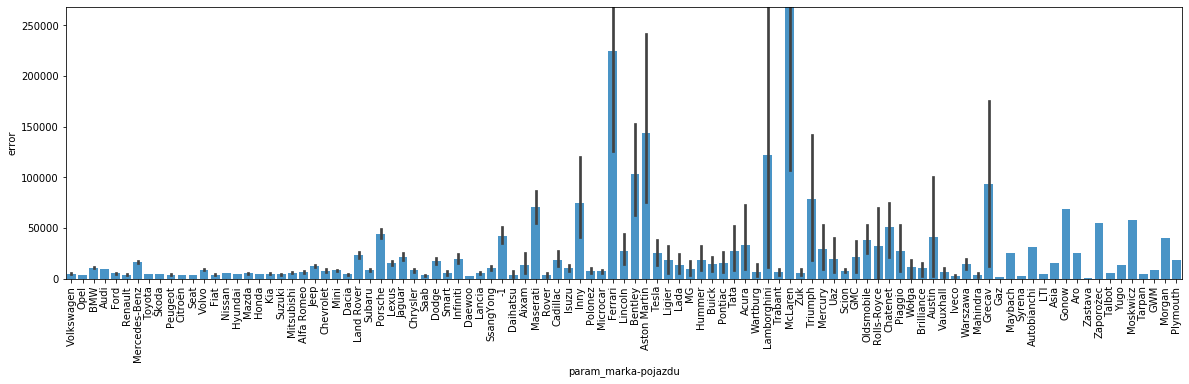

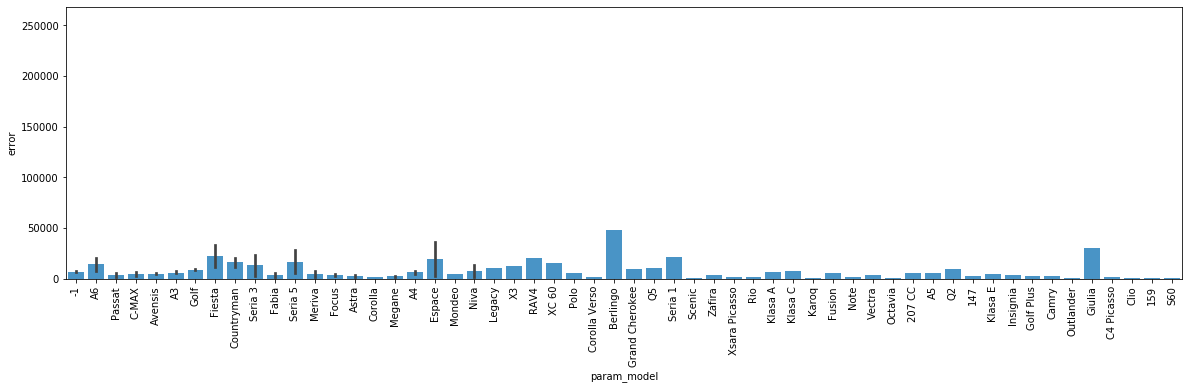

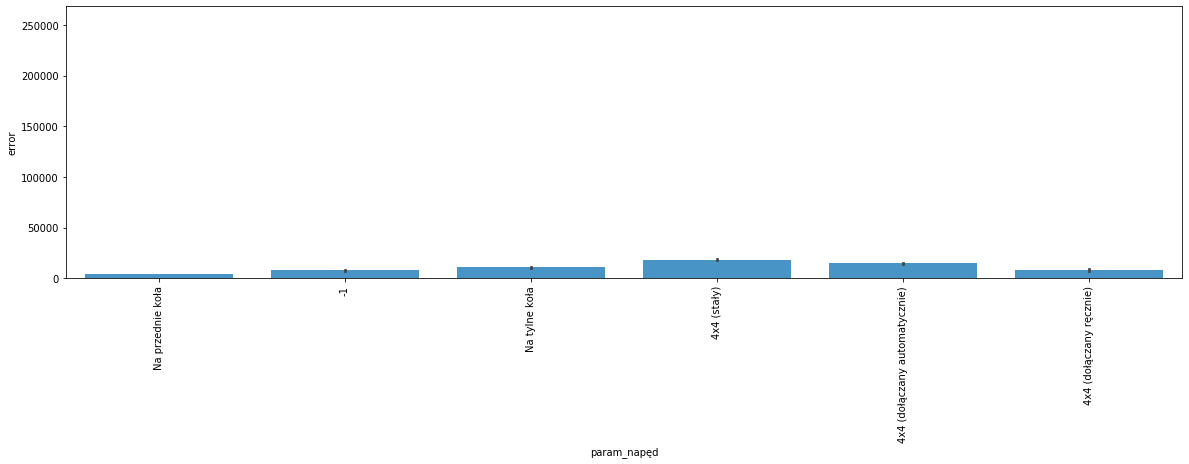

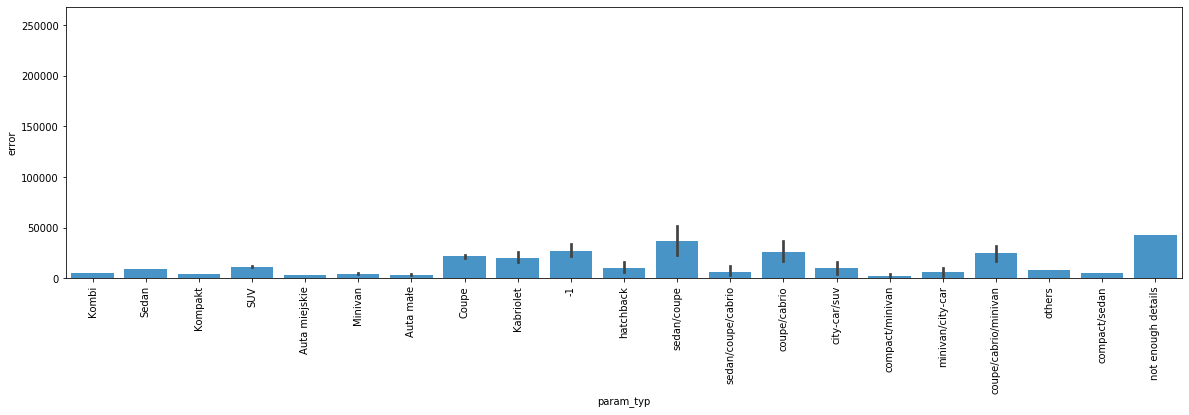

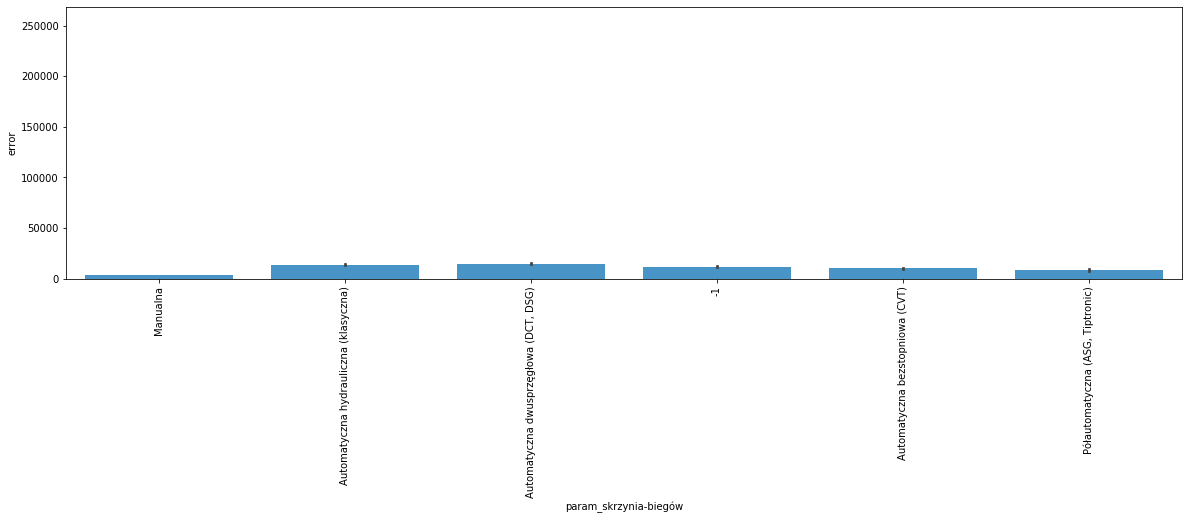

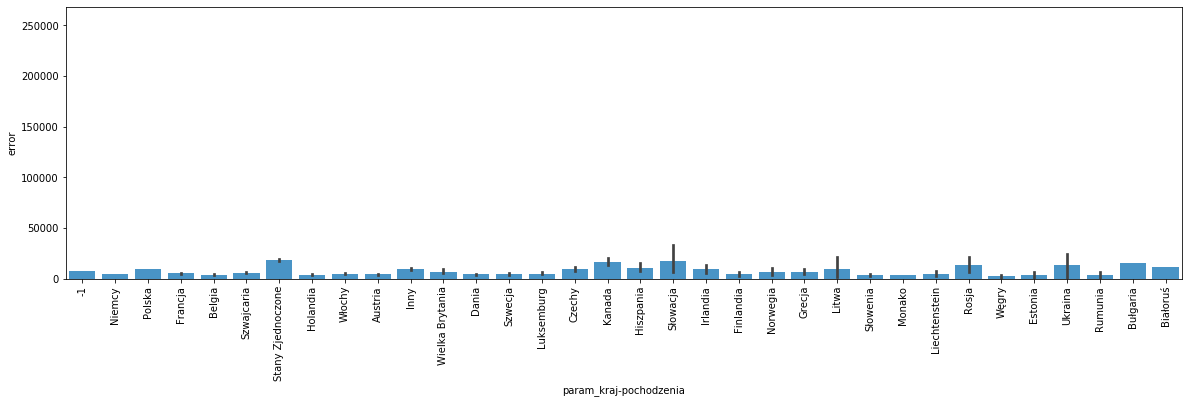

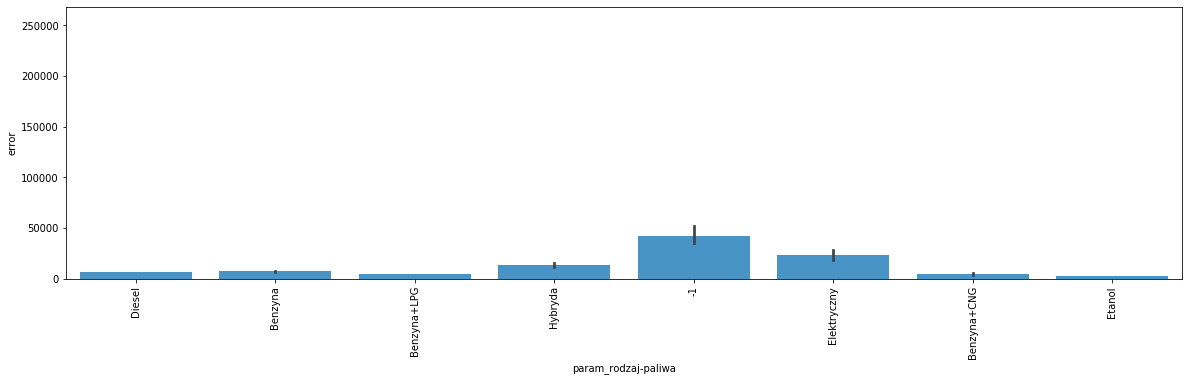

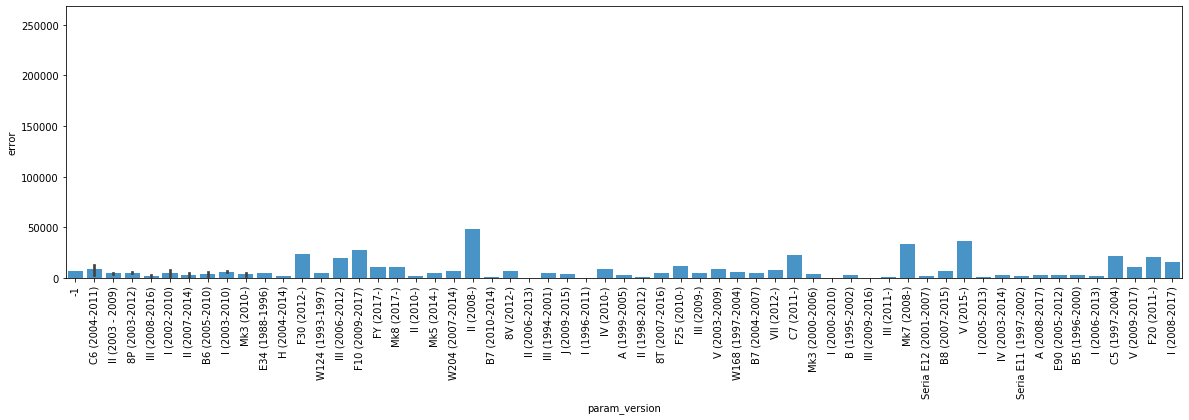

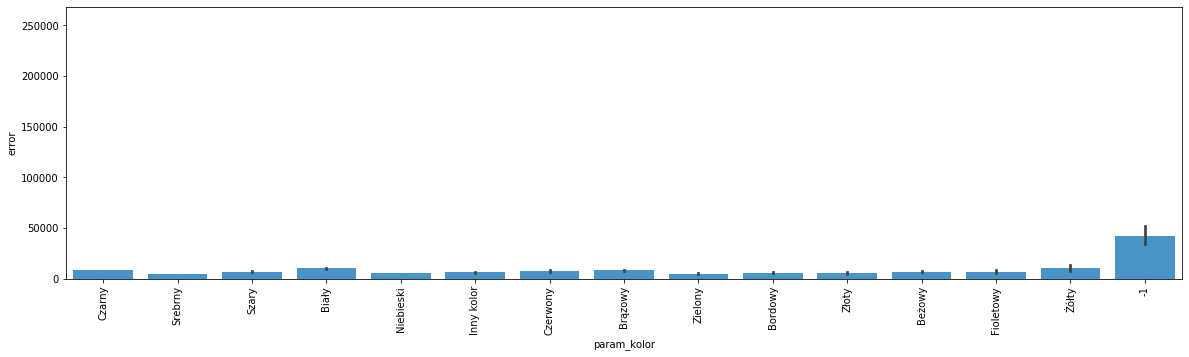

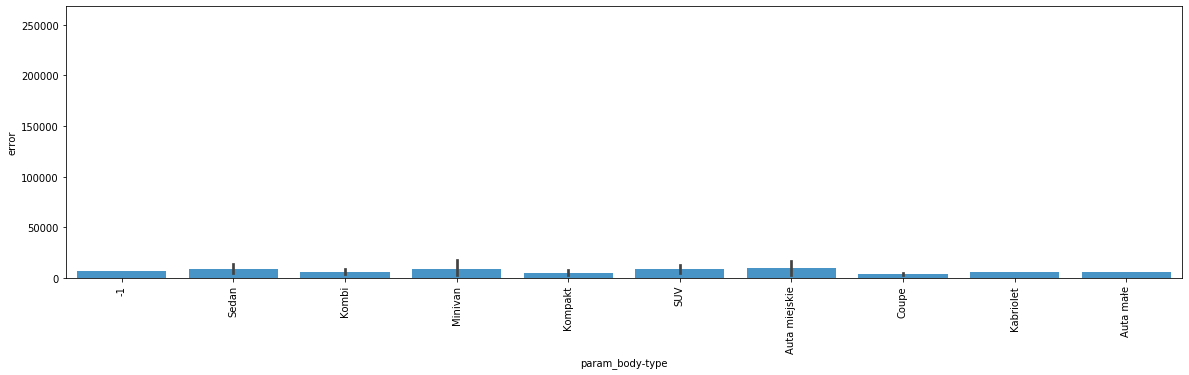

In [72]:
cat_to_check = [x for x in cat_feats if len(train[x].unique()) > 4]
cat_to_check = [x for x in cat_to_check if x not in cat_no_plot]

max_cat_mae = 0
for cat in cat_to_check:
    cat_mae = train.groupby(cat).agg(mae=('error', np.mean))['mae'].max()
    if cat_mae > max_cat_mae:
        max_cat_mae = cat_mae

for cat_feat in cat_to_check:
    cat_name = cat_feat[:-len(cat_feat_prefix)]
    plt.figure(figsize=(20,5))
    order = train.groupby(cat_name)['error'].agg(np.mean).reset_index().sort_values('error', ascending=False)[cat_name]
    ax = sns.barplot(x=cat_name, y='error', data=train, order=train[cat_name].value_counts().index, color='#3498db');
    plt.xticks(rotation=90);
    ax.set(ylim=(0, max_cat_mae))
    plt.show()

Error analysis shown above aloved to draw conclusions listed below:
 - Replacing missing error with -1 did not generate such big error that using more time consuming methods would be justified.
 - Even though the luxury car feature was added and is in top most important features the luxury car segment is still generating most error. It would be a buisnes decision if company using this model is considering working with luxury cars if so more data regarding this segment should be gathered.
  

In [73]:
train_no_lux = train[ ~train['luxury_car'] ]
get_X_y_and_cros_val(train_no_lux, model, feats, log=True)

(6674.85875716664, 75.68387520885118)

In [262]:
feats_to_agg = ['param_marka-pojazdu']
agg_feat_prefix = '__agg'

for feat_to_agg in feats_to_agg:
    train[feat_to_agg + agg_feat_prefix] = pd.Series([np.nan] * train.shape[0])

agg_feats = [x for x in train.columns if agg_feat_prefix in x]

In [118]:
'param_marka-pojazdu__agg'[:-len(agg_feat_prefix)]

'param_marka-pojazdu'

In [ ]:
def get_X_y_and_cros_val(df, model, feats, log=False):

    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        train_df = df[ df.index.isin(train_idx) ]
        test_df = df[ df.index.isin(test_idx) ]
        reset_agg_feats(df)
        
        _dict = agg_fetures_dict(train_df)
        for agg_feat in agg_feats:
            test_df[agg_feat] = test_df[agg_feat[:-len(agg_feat_prefix)]].map(_dict[agg_feat])
        
        # train kFold agg features
        k_fold_agg_fetures(dftrain_idx)
        
        
        
        
        
        
        X = df[ feats ].values
        y = df['price_value_PLN'].values if not log else train_df['price_value_PLN_log'].values
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        y_pred = train_model.predict(X[test_idx])
        
        y_pred = np.expm1(y_pred) if log else y_pred
        y_test = np.expm1(y[test_idx]) if log else y[test_idx]
              
        score = mean_absolute_error(y_test, y_pred)
        
        scores.append(score)
    return np.mean(scores), np.std(scores)

In [131]:
k_fold_agg_fetures(train)

KeyError: 'param_marka-pojazdu'

In [269]:
train.head()

,index,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,para

In [314]:
train.iloc[[1],:]['param_marka-pojazdu__agg']=1

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [324]:
train.loc[[1],'param_marka-pojazdu__agg'] = 1

In [325]:
train.head(1)

,index,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,para

In [327]:
k_fold_agg_fetures(train)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


(106494, 214)
70996
106493
(106494, 214)
35498
106493
(106494, 214)
0
106493


In [333]:
a = pd.DataFrame()
a['c'] = [1,2,3]
a.index.values

array([0, 1, 2])

In [326]:
def reset_agg_feats(df):
    for agg_feat in agg_feats:
        df[agg_feat] = pd.Series([np.nan] * df.shape[0])

def k_fold_agg_fetures(df):
    
    df_feats = pd.DataFrame()
    df_feats['idxs'] = df.index.values
    df_feats.set_index('idxs')
    
    a = pd.Series([np.nan] * df.shape[0])
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    for get_data_idx, store_data_idx in cv.split(df.index.values):
        get_df = df.iloc[list(get_data_idx),:] 
        _dict = group_to_dict('param_marka-pojazdu')
        
        for agg_feat in agg_feats:
            to_agg_feat = agg_feat[:-len(agg_feat_prefix)]
            store_df[agg_feat] = store_df[to_agg_feat].map(lambda x: _dict[to_agg_feat][x])
            a[store_data_idx] = store_df[to_agg_feat].map(lambda x: _dict[to_agg_feat][x])
            
        
        print(df.shape)
        print(a.isnull().sum())
        print(df['param_marka-pojazdu__agg'].isnull().sum())
                                    
# def agg_fetures_dict(df):
#     _dict = {}
#     for agg_feat in agg_feats:
#         to_agg_feat = agg_feat[:-len(agg_feat_prefix)]
#         _dict[to_agg_feat] = group_to_dict(df, to_agg_feat)
#     return _dict

def group_to_dict(df, group_key):
    target_variable = 'price_value_PLN_log'
    to_group = df[[group_key, target_variable]]
    _dict =  to_group.groupby([group_key]).agg(np.mean).to_dict()[target_variable]
    mean = np.mean( list(_dict.values()) )
    return defaultdict(lambda: mean, _dict)

In [105]:
cv = KFold(n_splits=3, random_state=0, shuffle=True)

for train_idx, test_idx in cv.split(y):
    print(train[train.index.isin(train_idx)])

                                               breadcrumb  \
2       [Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...   
3       [Osobowe, Porsche, Cayenne, Porsche Cayenne II...   
4       [Osobowe, Peugeot, 308, Peugeot 308 T7 (2008-2...   
5       [Osobowe, Volkswagen, Golf, Volkswagen Golf VI...   
7                                [Osobowe, Jeep, Compass]   
...                                                   ...   
160606  [Osobowe, Nissan, Qashqai, Nissan Qashqai II (...   
160610                            [Osobowe, Škoda, RAPID]   
160611  [Osobowe, Opel, Zafira, Opel Zafira B (2005-20...   
160614  [Osobowe, Volkswagen, Passat, Volkswagen Passa...   
160615                            [Osobowe, Peugeot, 207]   

                   created_at price_currency  \
2         15:48, 5 marca 2018            PLN   
3         06:30, 4 marca 2018            PLN   
4         08:46, 3 marca 2018            PLN   
5         20:00, 3 marca 2018            PLN   
7         17:15, 4 marca 20

                                               breadcrumb  \
0         [Osobowe, Dacia, Logan, Dacia Logan II (2012-)]   
3       [Osobowe, Porsche, Cayenne, Porsche Cayenne II...   
6       [Osobowe, Škoda, Octavia, Škoda Octavia II (20...   
7                                [Osobowe, Jeep, Compass]   
11                       [Osobowe, Volkswagen, Golf Plus]   
...                                                   ...   
160609  [Osobowe, Hyundai, i20, Hyundai i20 I (2008-20...   
160610                            [Osobowe, Škoda, RAPID]   
160611  [Osobowe, Opel, Zafira, Opel Zafira B (2005-20...   
160614  [Osobowe, Volkswagen, Passat, Volkswagen Passa...   
160615                            [Osobowe, Peugeot, 207]   

                   created_at price_currency  \
0         13:23, 5 marca 2018            PLN   
3         06:30, 4 marca 2018            PLN   
6         10:42, 5 marca 2018            PLN   
7         17:15, 4 marca 2018            PLN   
11      11:46, 28 lutego 20

In [73]:
[x for x in less_feats if cat_feat_prefix in x]

['param_napęd__cat',
 'param_rodzaj-paliwa__cat',
 'param_bezwypadkowy__cat',
 'param_skrzynia-biegów__cat',
 'param_oferta-od__cat',
 'param_marka-pojazdu__cat',
 'param_stan__cat',
 'param_faktura-vat__cat',
 'param_kod-silnika__cat',
 'param_uszkodzony__cat',
 'param_wersja__cat',
 'seller_name__cat',
 'param_typ__cat']

In [84]:
group_to_dict(train, 'param_napęd')

{-1: 9.898296745734047,
 '4x4 (dołączany automatycznie)': 11.24924150422175,
 '4x4 (dołączany ręcznie)': 10.325656116717951,
 '4x4 (stały)': 11.361983501009224,
 'Na przednie koła': 10.03018328985807,
 'Na tylne koła': 10.42203913923541}

In [70]:
train.groupby(['param_napęd']).agg(np.mean)

,price_value,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,param_zarejestrowany-w-polsce__cat,param_oferta-od__cat,param_kraj-pochodzenia__cat,param_serwisowany-w-aso__cat,param_rodzaj-paliwa__cat,param_możliwość-finansowania__cat,param_registered-in-poland__cat,param_kod-silnika__cat,param_version__cat,param_model-pojazdu__cat,param_kierownica-po-prawej-(anglik)__cat,param_vat-free__cat,param_acrylic__cat,param_damaged__cat,param_tuning__cat,param_filtr-cząstek-stałych__cat,param_nr-of-seats__cat,param_kolor__cat,param_pearl__cat,param_stan__cat,param_wersja__cat,param_body-type__cat,param_matowy__cat,param_bezwypadkowy__cat,param_akryl-(niemetalizowany)__cat,param_monthly-payment-value__cat,param_liczba-miejsc__num,param_liczba-drzwi__num,param_przebieg__num,param_moc__num,param_pojemność-skokowa__num,param_emisja-co2__num,param_wartość-wykupu__num,param_miesięczna-rata__num,param_opłata-początkowa__num,param_rok-produkcji__num,param_przebieg__num__log,param_moc__num__log,param_pojemność-skokowa__num__log,luxury_car
param_napęd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,33730.623525,0.153357,0.115232,0.343798,0.246925,0.122086,0.240622,0.698366,0.425005,0.782755,0.687167,0.778471,0.755156,0.101157,0.205679,0.515758,0.381250,0.298635,0.261551,0.291231,0.431859,0.021174,0.044489,0.016951

In [102]:
train.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,param_zare

In [103]:
train[train.index.isin([2,3])]

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_pierwsza-rejestracja,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_leasing,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_kraj-pochodzenia,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_vat-free,param_acrylic,param_damaged,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log,seller_address__cat,seller_name__cat,seller_type__cat,param_uszkodzony__cat,param_marka-pojazdu__cat,param_model__cat,param_engine-code__cat,param_faktura-vat__cat,param_vin__cat,param_perłowy__cat,param_homologacja-ciężarowa__cat,param_service-record__cat,param_metallic__cat,param_leasing-concession__cat,param_financing-option__cat,param_original-owner__cat,param_vat-marża__cat,param_kategoria__cat,param_leasing__cat,param_zarejestrowany-jako-zabytek__cat,param_napęd__cat,param_typ__cat,param_metalik__cat,param_pierwszy-właściciel__cat,param_skrzynia-biegów__cat,param_vat-discount__cat,param_no-accident__cat,param_particle-filter__cat,param_zare

In [4]:
d = {'idx':[2,3], 'ddd':['a', 'a']}
df1 = pd.DataFrame(data=d)

In [94]:
df1.index = df1['idx']

df1.head()

,idx,ddd
idx,,
2,2,a
3,3,a


# Final predict and submit data preparation

In [ ]:
test.sample()

In [ ]:
model = XGBRegressor(**xgb_params)

model.fit(train[feats], train['price_value_PLN'])
test['price_value_PLN'] = model.predict(test[feats])
########### exp
test['price_value'] = test[['price_value_PLN', 'price_currency']].apply(lambda x: x['price_value_PLN'] if x['price_currency'] == 'PLN' else x['price_value_PLN'] / 4.5, axis =1)

test[ ['car_id', 'price_value'] ].to_csv('../car_test_predict.csv', index=False)

# osiągnąć top 10 Mało brakuje